# Capstone Phase 2 - Modeling  
The previous notebook (capstone-phase1) was getting a bit long to run comfortably, so let's start a new one for ML.


### Import some libraries we'll need

In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn import preprocessing
from zipfile import ZipFile

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

### Some Utility stuff

In [4]:
def plt_norm_confmat(model, X, y, title, fname=None, labels=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    display = plot_confusion_matrix(model, X, y, display_labels=labels, cmap=plt.cm.Blues, 
                                    normalize='true', xticks_rotation='vertical', ax=ax)
    display.ax_.set_title(title)
    if fname is not None:
        file = './images/' + fname + '.png'
        plt.savefig(file, dpi=300, bbox_inches='tight')

In [5]:
def transform_data(df):
    no_labels = df.drop(['label', 'attack_cat'], axis=1)
    one_hot = pd.get_dummies(no_labels, columns=['proto', 'service', 'state'], prefix=['proto', 'service', 'state'])
    scaler = preprocessing.StandardScaler().fit(one_hot)
    standardized = scaler.transform(one_hot)
    std = pd.DataFrame(standardized, columns=one_hot.columns)

    labels = df['label'].copy()
    cats = df['attack_cat'].copy()
    
    return std, labels, cats

In [27]:
def gen_metrics(y_train, y_pred):
    conf_mat = confusion_matrix(y_train, y_pred)
    class_rep = classification_report(y_train, y_pred, zero_division=0)
    rep_dict = classification_report(y_train, y_pred, zero_division=0, output_dict=True)
    acc = accuracy_score(y_train, y_pred)
    return conf_mat, class_rep, rep_dict, acc

### Load data and apply Transformations identified during exploration phase.

In [6]:
with ZipFile('./Data/UNSW_NB15 training and testing sets.zip') as datasets_zip:
    # open each file and read in to a DataFrame
    with datasets_zip.open('UNSW_NB15_training-set.csv') as training_file:
        training_data = pd.read_csv(training_file, index_col='id')
    with datasets_zip.open('UNSW_NB15_testing-set.csv') as testing_file:
        testing_data = pd.read_csv(testing_file, index_col='id')

In [7]:
training_data_std, training_labels, training_cats = transform_data(training_data)
testing_data_std, testing_labels, testing_cats = transform_data(testing_data)

In [8]:
# let's check it
training_data_std.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ssl,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,-0.191029,-0.104456,-0.135769,-0.049134,-0.102726,-0.576371,0.703839,1.578100,-0.389897,-0.273700,...,-0.017874,-0.284764,-0.008273,1.119382,-0.940239,-0.002388,-0.10717,-0.021762,-0.002388,-0.002388
1,-0.109485,-0.046014,0.172599,-0.046410,0.188544,-0.576345,-1.141901,1.560002,-0.389928,-0.069233,...,-0.017874,-0.284764,-0.008273,1.119382,-0.940239,-0.002388,-0.10717,-0.021762,-0.002388,-0.002388
2,0.040699,-0.089845,-0.026933,-0.048527,-0.012133,-0.576734,-1.141901,1.560002,-0.389964,-0.252044,...,-0.017874,-0.284764,-0.008273,1.119382,-0.940239,-0.002388,-0.10717,-0.021762,-0.002388,-0.002388
3,0.049729,-0.060624,-0.063212,-0.047016,-0.098563,-0.576737,-1.141901,1.560002,-0.389958,-0.275821,...,-0.017874,-0.284764,-0.008273,1.119382,-0.940239,-0.002388,-0.10717,-0.021762,-0.002388,-0.002388
4,-0.140417,-0.075235,-0.117630,-0.047554,-0.102057,-0.576617,0.723268,1.560002,-0.389927,-0.275561,...,-0.017874,-0.284764,-0.008273,1.119382,-0.940239,-0.002388,-0.10717,-0.021762,-0.002388,-0.002388


Let's transform the labels using `preprocessing.LabelEncoder`, it can easily transform between encoding and original labels.  
~~Let's also try a simple integer mapping for the classes, it might work better for some methods.~~

In [9]:
#y_train = training_cats.map({'Normal':0, 'Generic':1, 'Exploits':2, 'Fuzzers':3, 'DoS':4, 
#                           'Reconnaissance':5, 'Analysis':6, 'Backdoor':7, 'Shellcode':8, 'Worms':9}).astype(int)
#y_test = testing_cats.map({'Normal':0, 'Generic':1, 'Exploits':2, 'Fuzzers':3, 'DoS':4, 
#                           'Reconnaissance':5, 'Analysis':6, 'Backdoor':7, 'Shellcode':8, 'Worms':9}).astype(int)

label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(training_cats)
y_test = label_encoder.fit_transform(testing_cats)

In [10]:
training_cats.unique()

array(['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode',
       'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic'],
      dtype=object)

In [11]:
label_encoder.classes_

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

In [12]:
class_names = list(label_encoder.classes_)
#class_names = ['Normal', 'Generic', 'Exploits', 'Fuzzers', 'DoS', 'Reconnaissance', 'Analysis', 'Backdoor', 'Shellcode', 'Worms']

In [13]:
print(class_names)

['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Normal', 'Reconnaissance', 'Shellcode', 'Worms']


We can also transform the labels in to a binary vector with `preprocessing.LabelBinarizer` if that is preferred by some methods.

In [13]:
# Use LabelBinarizer to convert target classes to binary vectors
binarizer = preprocessing.LabelBinarizer()
y_train_bin = binarizer.fit_transform(training_cats)
y_test_bin = binarizer.fit_transform(testing_cats)
#print(binarizer.classes_)

### Load feature subsets

In [14]:
feature_subsets = joblib.load('./data/feature_subsets.pkl')

In [15]:
feature_subsets.keys()

dict_keys(['ig', 'anova', 'vt', 'mad', 'corr', 'rfe'])

In [16]:
#checking something...
for key, vals in feature_subsets.items():
    if 'is_sm_ips_ports' in vals:
        print(f'{key} features contains is_sm_ips_ports')

corr features contains is_sm_ips_ports
rfe features contains is_sm_ips_ports


In [17]:
#subsets = pd.read_pickle("./data/subsets.pkl")
#subsets.head()

Make a new DataFrame for each feature subset.

In [16]:
train_std_ig = training_data_std[feature_subsets['ig']].copy()
test_std_ig = testing_data_std[feature_subsets['ig']].copy()

train_std_anova = training_data_std[feature_subsets['anova']].copy()
test_std_anova = testing_data_std[feature_subsets['anova']].copy()

train_std_vt = training_data_std[feature_subsets['vt']].copy()
test_std_vt = testing_data_std[feature_subsets['vt']].copy()

train_std_mad = training_data_std[feature_subsets['mad']].copy()
test_std_mad = testing_data_std[feature_subsets['mad']].copy()

train_std_corr = training_data_std[feature_subsets['corr']].copy()
test_std_corr = testing_data_std[feature_subsets['corr']].copy()

train_std_rfe = training_data_std[feature_subsets['rfe']].copy()
test_std_rfe = testing_data_std[feature_subsets['rfe']].copy()

In [17]:
train_std_ig.head()

,sbytes,smean,sload,dbytes,rate,dmean,dur,ct_dst_sport_ltm,ct_srv_dst,ct_state_ttl,dttl,ct_srv_src,dload,ct_dst_src_ltm,dinpkt,sttl,ct_src_dport_ltm,dpkts,ct_dst_ltm,sinpkt
0,-0.049134,-0.458048,-0.389897,-0.102726,-0.576371,-0.314240,-0.191029,-0.554373,-0.753074,-1.366486,1.578100,-0.775991,-0.273700,-0.705529,-0.080885,0.703839,-0.544736,-0.135769,-0.645013,-0.132788
1,-0.046410,-0.414076,-0.389928,0.188544,-0.576345,3.800869,-0.109485,-0.554373,-0.288257,-0.318711,1.560002,3.147666,-0.069233,-0.614256,-0.073735,-1.141901,-0.544736,0.172599,-0.645013,-0.129251
2,-0.048527,-0.443391,-0.389964,-0.012133,-0.576734,2.709185,0.040699,-0.554373,-0.288257,-0.318711,1.560002,-0.215468,-0.252044,-0.522983,0.014711,-1.141901,-0.544736,-0.026933,-0.520827,-0.104126
3,-0.047016,-0.414076,-0.389958,-0.098563,-0.576737,-0.232945,0.049729,-0.554373,-0.753074,-0.318711,1.560002,-0.775991,-0.275821,-0.522983,0.002046,-1.141901,-0.544736,-0.063212,-0.520827,-0.115034
4,-0.047554,-0.409190,-0.389927,-0.102057,-0.576617,-0.306498,-0.140417,-0.554373,2.779535,-0.318711,1.560002,3.147666,-0.275561,2.854115,-0.012721,0.723268,-0.420468,-0.117630,-0.520827,-0.129549


# Modeling

## Let's try a Naive Bayes classifier  
https://scikit-learn.org/stable/modules/naive_bayes.html

Neither ComplementNB, nor MultinomialNB likes negative values.  Should I have used some other type of normalization instead of the Standard Scaler? Something that would generate only non-negative values? MinMaxScaler [0,1] "is often used as an alternative to zero mean, unit variance scaling"  
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler

In [25]:
#from sklearn.naive_bayes import ComplementNB
#from sklearn.naive_bayes import MultinomialNB

In [26]:
#mnb_params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}
#mnb_gs = GridSearchCV(MultinomialNB(), mnb_params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

In [27]:
#mnb_gs_results = mnb_gs.fit(train_std_ig, y_train)

In [28]:
#train_std_ig.head()

In [29]:
#print(mnb_gs_results.best_score_)
#print(mnb_gs_results.best_estimator_)
#print(mnb_gs_results.best_params_)

#### Try Gaussian NB....

In [18]:
from sklearn.naive_bayes import GaussianNB

In [42]:
gnb = GaussianNB()
gnb.fit(train_std_ig, y_train)
cv_scores = cross_val_score(gnb, train_std_ig, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print('Cross validation scores: ', cv_scores)
print('Mean score: ', cv_scores.mean())
print('Standard Dev: ', cv_scores.std())

Cross validation scores:  [0.54914597 0.5327364  0.54639557 0.46823315 0.39842592]
Mean score:  0.498987400787217
Standard Dev:  0.0582423354572515


In [12]:
joblib.dump(gnb, './data/gnb_model_ig.pkl')
#gnb = joblib.load('./data/gnb_model_ig.pkl')

In [13]:
#y_pred_gnb = gnb.predict(test_std_ig)
y_pred_gnb = cross_val_predict(gnb, train_std_ig, y_train, cv=5)  # save the test set for final models
y_pred_gnb

array([7, 6, 3, ..., 1, 5, 5])

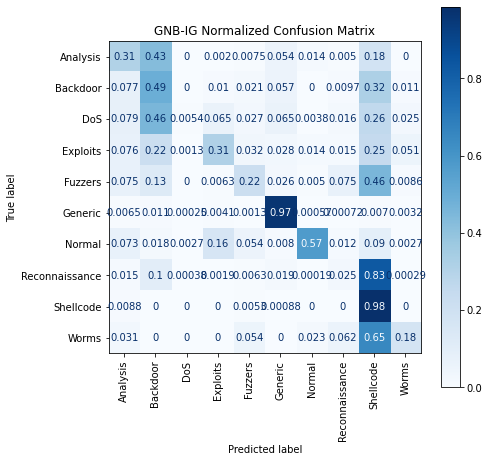

              precision    recall  f1-score   support

           0       0.05      0.35      0.09      2000
           1       0.04      0.40      0.08      1746
           2       0.22      0.01      0.01     12264
           3       0.49      0.31      0.38     33393
           4       0.46      0.22      0.30     18184
           5       0.92      0.97      0.94     40000
           6       0.98      0.56      0.72     56000
           7       0.08      0.03      0.04     10491
           8       0.03      0.98      0.06      1133
           9       0.01      0.17      0.02       130

    accuracy                           0.50    175341
   macro avg       0.33      0.40      0.26    175341
weighted avg       0.69      0.50      0.55    175341

0.4989876868501948


In [48]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_gnb = confusion_matrix(y_train, y_pred_gnb)
#print(con_mat_gnb)
plt_norm_confmat(gnb, train_std_ig, y_train, 'GNB-IG Normalized Confusion Matrix', 
                 fname='gnb_ig_conf_mat', labels=class_names)
plt.show()
class_rep_gnb = classification_report(y_train, y_pred_gnb, zero_division=0)
rep_dict_gnb_ig = classification_report(y_train, y_pred_gnb, zero_division=0, output_dict=True)
print(class_rep_gnb)
acc_gnb = accuracy_score(y_train, y_pred_gnb)
print(acc_gnb)

In [15]:
#rep_dict_gnb_ig = classification_report(y_train, y_pred_gnb, zero_division=0, output_dict=True)

In [16]:
joblib.dump(rep_dict_gnb_ig, './data/rep_dict_gnb_ig.pkl')

['./data/rep_dict_gnb_ig.pkl']

Try GaussianNB on the other feature sets

In [56]:
# ANOVA selected features
gnb_anova = GaussianNB()
gnb_anova.fit(train_std_anova, y_train)
cv_scores_anova = cross_val_score(gnb_anova, train_std_anova, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print('Cross validation scores: ', cv_scores_anova)
print('Mean score: ', cv_scores_anova.mean())
print('Standard Dev: ', cv_scores_anova.std())

Cross validation scores:  [0.57814594 0.56866659 0.56812479 0.50761378 0.33928368]
Mean score:  0.5123669547967329
Standard Dev:  0.09009536430085348


In [17]:
joblib.dump(gnb_anova, './data/gnb_model_anova.pkl')
#gnb_anova = joblib.load('./data/gnb_model_anova.pkl')

In [18]:
#y_pred_gnb_anova = gnb_anova.predict(test_std_anova)
y_pred_gnb_anova = cross_val_predict(gnb_anova, train_std_anova, y_train, cv=5)  # save the test set for final models
y_pred_gnb_anova

array([7, 6, 3, ..., 5, 5, 5])

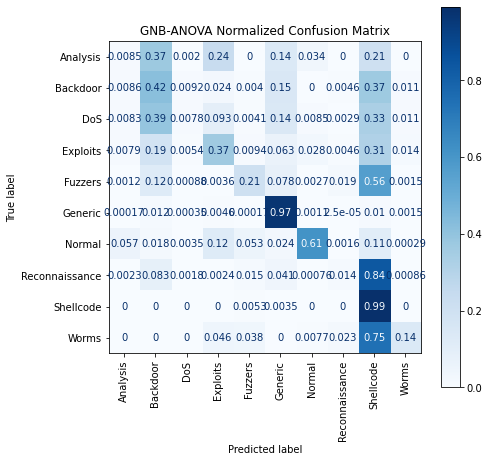

              precision    recall  f1-score   support

           0       0.00      0.01      0.00      2000
           1       0.04      0.40      0.08      1746
           2       0.19      0.01      0.02     12264
           3       0.55      0.37      0.44     33393
           4       0.51      0.21      0.29     18184
           5       0.83      0.97      0.89     40000
           6       0.97      0.59      0.73     56000
           7       0.17      0.01      0.02     10491
           8       0.03      0.99      0.05      1133
           9       0.02      0.14      0.03       130

    accuracy                           0.51    175341
   macro avg       0.33      0.37      0.26    175341
weighted avg       0.68      0.51      0.56    175341

0.5123673299456488


In [59]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_gnb_anova = confusion_matrix(y_train, y_pred_gnb_anova)
#print(con_mat_gnb_anova)
plt_norm_confmat(gnb_anova, train_std_anova, y_train, 'GNB-ANOVA Normalized Confusion Matrix', 
                 fname='gnb_anova_conf_mat', labels=class_names)
plt.show()
class_rep_gnb_anova = classification_report(y_train, y_pred_gnb_anova, zero_division=0)
rep_dict_gnb_anova = classification_report(y_train, y_pred_gnb_anova, zero_division=0, output_dict=True)
print(class_rep_gnb_anova)
acc_gnb_anova = accuracy_score(y_train, y_pred_gnb_anova)
print(acc_gnb_anova)

In [19]:
#rep_dict_gnb_anova = classification_report(y_train, y_pred_gnb_anova, zero_division=0, output_dict=True)

In [21]:
joblib.dump(rep_dict_gnb_anova, './data/rep_dict_gnb_anova.pkl')

['./data/rep_dict_gnb_anova.pkl']

Next subset...

In [60]:
# Variance Threshold selected features
gnb_vt = GaussianNB()
gnb_vt.fit(train_std_vt, y_train)
cv_scores_vt = cross_val_score(gnb_vt, train_std_vt, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print('Cross validation scores: ', cv_scores_vt)
print('Mean score: ', cv_scores_vt.mean())
print('Standard Dev: ', cv_scores_vt.std())

Cross validation scores:  [0.3518207  0.34897913 0.34915022 0.25039922 0.15381544]
Mean score:  0.29083294273584837
Standard Dev:  0.0786257849871457


In [22]:
joblib.dump(gnb_vt, './data/gnb_model_vt.pkl')
#gnb_vt = joblib.load('./data/gnb_model_vt.pkl')

In [23]:
#y_pred_gnb_vt = gnb_vt.predict(test_std_vt)
y_pred_gnb_vt = cross_val_predict(gnb_vt, train_std_vt, y_train, cv=5)  # save the test set for final models
y_pred_gnb_vt

array([7, 6, 3, ..., 8, 8, 8])

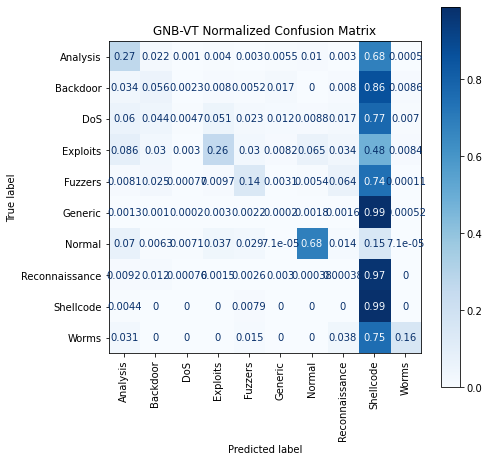

              precision    recall  f1-score   support

           0       0.06      0.26      0.10      2000
           1       0.04      0.06      0.04      1746
           2       0.10      0.00      0.01     12264
           3       0.72      0.26      0.38     33393
           4       0.45      0.14      0.22     18184
           5       0.02      0.00      0.00     40000
           6       0.94      0.68      0.79     56000
           7       0.00      0.00      0.00     10491
           8       0.01      0.99      0.02      1133
           9       0.04      0.16      0.07       130

    accuracy                           0.29    175341
   macro avg       0.24      0.25      0.16    175341
weighted avg       0.50      0.29      0.35    175341

0.29083329055953827


In [63]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_gnb_vt = confusion_matrix(y_train, y_pred_gnb_vt)
#print(con_mat_gnb_vt)
plt_norm_confmat(gnb_vt, train_std_vt, y_train, 'GNB-VT Normalized Confusion Matrix', 
                 fname='gnb_vt_conf_mat', labels=class_names)
plt.show()
class_rep_gnb_vt = classification_report(y_train, y_pred_gnb_vt, zero_division=0)
rep_dict_gnb_vt = classification_report(y_train, y_pred_gnb_vt, zero_division=0, output_dict=True)
print(class_rep_gnb_vt)
acc_gnb_vt = accuracy_score(y_train, y_pred_gnb_vt)
print(acc_gnb_vt)

In [24]:
#rep_dict_gnb_vt = classification_report(y_train, y_pred_gnb_vt, zero_division=0, output_dict=True)

In [25]:
joblib.dump(rep_dict_gnb_vt, './data/rep_dict_gnb_vt.pkl')

['./data/rep_dict_gnb_vt.pkl']

Next subset...

In [64]:
# Median Absolute Deviation selected features
gnb_mad = GaussianNB()
gnb_mad.fit(train_std_mad, y_train)
cv_scores_mad = cross_val_score(gnb_mad, train_std_mad, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print('Cross validation scores: ', cv_scores_mad)
print('Mean score: ', cv_scores_mad.mean())
print('Standard Dev: ', cv_scores_mad.std())

Cross validation scores:  [0.55156976 0.54035018 0.55754534 0.48984829 0.38405384]
Mean score:  0.5046734825495467
Standard Dev:  0.06486355791466777


In [26]:
joblib.dump(gnb_mad, './data/gnb_model_mad.pkl')
#gnb_mad = joblib.load('./data/gnb_model_mad.pkl')

In [27]:
#y_pred_gnb_mad = gnb_mad.predict(test_std_mad)
y_pred_gnb_mad = cross_val_predict(gnb_mad, train_std_mad, y_train, cv=5)  # save the test set for final models
y_pred_gnb_mad

array([7, 6, 3, ..., 5, 5, 5])

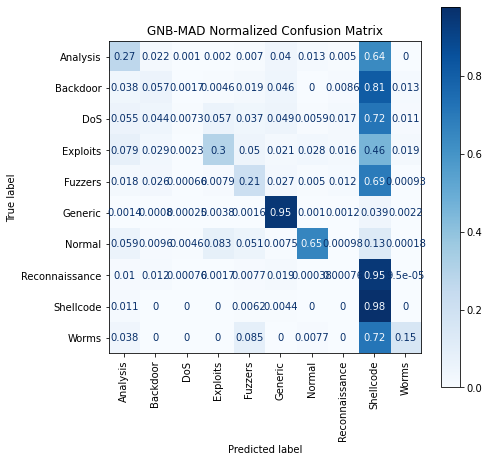

              precision    recall  f1-score   support

           0       0.06      0.25      0.10      2000
           1       0.04      0.06      0.04      1746
           2       0.20      0.01      0.01     12264
           3       0.58      0.30      0.39     33393
           4       0.43      0.21      0.28     18184
           5       0.93      0.95      0.94     40000
           6       0.97      0.63      0.76     56000
           7       0.01      0.00      0.00     10491
           8       0.02      0.98      0.04      1133
           9       0.02      0.15      0.03       130

    accuracy                           0.50    175341
   macro avg       0.32      0.35      0.26    175341
weighted avg       0.69      0.50      0.56    175341

0.504673750007129


In [96]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_gnb_mad = confusion_matrix(y_train, y_pred_gnb_mad)
#print(con_mat_gnb_mad)
plt_norm_confmat(gnb_mad, train_std_mad, y_train, 'GNB-MAD Normalized Confusion Matrix', 
                 fname='gnb_mad_conf_mat', labels=class_names)
plt.show()
class_rep_gnb_mad = classification_report(y_train, y_pred_gnb_mad, zero_division=0)
rep_dict_gnb_mad = classification_report(y_train, y_pred_gnb_mad, zero_division=0, output_dict=True)
print(class_rep_gnb_mad)
acc_gnb_mad = accuracy_score(y_train, y_pred_gnb_mad)
print(acc_gnb_mad)

In [28]:
#rep_dict_gnb_mad = classification_report(y_train, y_pred_gnb_mad, zero_division=0, output_dict=True)

In [29]:
joblib.dump(rep_dict_gnb_mad, './data/rep_dict_gnb_mad.pkl')

['./data/rep_dict_gnb_mad.pkl']

Next...

In [68]:
#y_train.transform(training_cats)

In [69]:
train_std_corr.columns

Index(['dur', 'spkts', 'dpkts', 'rate', 'sttl', 'sload', 'dload', 'dinpkt',
       'sjit', 'djit', 'swin', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_state_ttl', 'ct_dst_sport_ltm', 'is_ftp_login',
       'ct_flw_http_mthd', 'is_sm_ips_ports'],
      dtype='object')

In [70]:
# Correlation selected features
gnb_corr = GaussianNB()
gnb_corr.fit(train_std_corr, y_train)
cv_scores_corr = cross_val_score(gnb_corr, train_std_corr, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print('Cross validation scores: ', cv_scores_corr)
print('Mean score: ', cv_scores_corr.mean())
print('Standard Dev: ', cv_scores_corr.std())

Cross validation scores:  [0.4073113  0.41867229 0.43198928 0.3759838  0.37766625]
Mean score:  0.40232458474221183
Standard Dev:  0.02224400723604726


In [30]:
joblib.dump(gnb_corr, './data/gnb_model_corr.pkl')
#gnb_corr = joblib.load('./data/gnb_model_corr.pkl')

In [31]:
#y_pred_gnb_corr = gnb_corr.predict(test_std_corr)
y_pred_gnb_corr = cross_val_predict(gnb_corr, train_std_corr, y_train, cv=5)  # save the test set for final models
y_pred_gnb_corr

array([7, 3, 3, ..., 5, 5, 5])

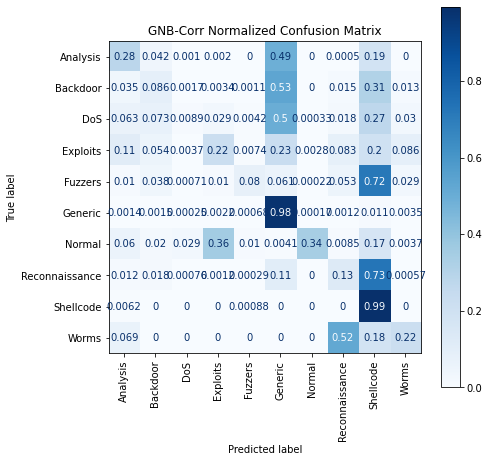

              precision    recall  f1-score   support

           0       0.06      0.28      0.10      2000
           1       0.03      0.09      0.05      1746
           2       0.06      0.01      0.02     12264
           3       0.27      0.23      0.25     33393
           4       0.61      0.08      0.14     18184
           5       0.68      0.98      0.80     40000
           6       0.99      0.34      0.51     56000
           7       0.23      0.13      0.17     10491
           8       0.03      0.99      0.05      1133
           9       0.01      0.22      0.01       130

    accuracy                           0.40    175341
   macro avg       0.30      0.33      0.21    175341
weighted avg       0.61      0.40      0.42    175341

0.40232461318231333


In [74]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_gnb_corr = confusion_matrix(y_train, y_pred_gnb_corr)
#print(con_mat_gnb_corr)
plt_norm_confmat(gnb_corr, train_std_corr, y_train, 'GNB-Corr Normalized Confusion Matrix', 
                 fname='gnb_corr_conf_mat', labels=class_names)
plt.show()
class_rep_gnb_corr = classification_report(y_train, y_pred_gnb_corr, zero_division=0)
rep_dict_gnb_corr = classification_report(y_train, y_pred_gnb_corr, zero_division=0, output_dict=True)
print(class_rep_gnb_corr)
acc_gnb_corr = accuracy_score(y_train, y_pred_gnb_corr)
print(acc_gnb_corr)

In [32]:
#rep_dict_gnb_corr = classification_report(y_train, y_pred_gnb_corr, zero_division=0, output_dict=True)

In [33]:
joblib.dump(rep_dict_gnb_corr, './data/rep_dict_gnb_corr.pkl')

['./data/rep_dict_gnb_corr.pkl']

Next subset...

In [87]:
#opt_list = joblib.load('./data/rfecv_selected_features.pkl')

In [45]:
#train_std_rfe = training_data_std[opt_list].copy()
#test_std_rfe = testing_data_std[opt_list].copy()

In [89]:
gnb_rfe = GaussianNB()
gnb_rfe.fit(train_std_rfe, y_train)
cv_scores_rfe = cross_val_score(gnb_rfe, train_std_rfe, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print('Cross validation scores: ', cv_scores_rfe)
print('Mean score: ', cv_scores_rfe.mean())
print('Standard Dev: ', cv_scores_rfe.std())

Cross validation scores:  [0.28147367 0.24241474 0.24352686 0.20779628 0.17751226]
Mean score:  0.2305447617562096
Standard Dev:  0.0353075741077206


In [34]:
joblib.dump(gnb_rfe, './data/gnb_model_rfe.pkl')
#gnb_rfe = joblib.load('./data/gnb_model_rfe.pkl')

In [35]:
#y_pred_gnb_rfe = gnb_rfe.predict(test_std_rfe)
y_pred_gnb_rfe = cross_val_predict(gnb_rfe, train_std_rfe, y_train, cv=5)  # save the test set for final models
y_pred_gnb_rfe

array([9, 6, 6, ..., 6, 6, 6])

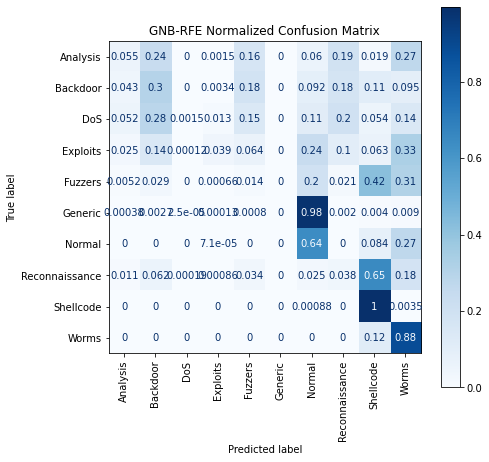

              precision    recall  f1-score   support

           0       0.05      0.04      0.05      2000
           1       0.05      0.28      0.08      1746
           2       0.48      0.00      0.00     12264
           3       0.87      0.04      0.07     33393
           4       0.05      0.01      0.01     18184
           5       0.01      0.00      0.01     40000
           6       0.41      0.66      0.51     56000
           7       0.06      0.01      0.01     10491
           8       0.05      1.00      0.09      1133
           9       0.00      0.85      0.01       130

    accuracy                           0.23    175341
   macro avg       0.20      0.29      0.08    175341
weighted avg       0.34      0.23      0.18    175341

0.23054505221254584


In [93]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_gnb_rfe = confusion_matrix(y_train, y_pred_gnb_rfe)
#print(con_mat_gnb_rfe)
plt_norm_confmat(gnb_rfe, train_std_rfe, y_train, 'GNB-RFE Normalized Confusion Matrix', 
                 fname='gnb_rfe_conf_mat', labels=class_names)
plt.show()
class_rep_gnb_rfe = classification_report(y_train, y_pred_gnb_rfe, zero_division=0)
rep_dict_gnb_rfe = classification_report(y_train, y_pred_gnb_rfe, zero_division=0, output_dict=True)
print(class_rep_gnb_rfe)
acc_gnb_rfe = accuracy_score(y_train, y_pred_gnb_rfe)
print(acc_gnb_rfe)

In [36]:
#rep_dict_gnb_rfe = classification_report(y_train, y_pred_gnb_rfe, zero_division=0, output_dict=True)

In [37]:
joblib.dump(rep_dict_gnb_rfe, './data/rep_dict_gnb_rfe.pkl')

['./data/rep_dict_gnb_rfe.pkl']

Here we see with a larger set of features, the model performs much worse - a limitation of the model.  
These are pretty terrible results, but NB isn't a very powerful algorithm.

In [ ]:
# reload class reports from previous run so we can plot them
rep_dict_gnb_ig = joblib.load('./data/rep_dict_gnb_ig.pkl')
rep_dict_gnb_anova = joblib.load('./data/rep_dict_gnb_anova.pkl')
rep_dict_gnb_vt = joblib.load('./data/rep_dict_gnb_vt.pkl')
rep_dict_gnb_mad = joblib.load('./data/rep_dict_gnb_mad.pkl')
rep_dict_gnb_corr = joblib.load('./data/rep_dict_gnb_corr.pkl')
rep_dict_gnb_rfe = joblib.load('./data/rep_dict_gnb_rfe.pkl')

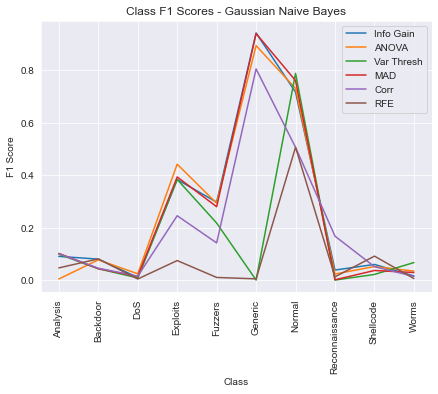

In [189]:
reports = [rep_dict_gnb_ig, rep_dict_gnb_anova, rep_dict_gnb_vt, rep_dict_gnb_mad, rep_dict_gnb_corr, rep_dict_gnb_rfe]
lgnds = ['Info Gain', 'ANOVA', 'Var Thresh', 'MAD', 'Corr', 'RFE']
labels = ['0', '1', '2', '3','4', '5', '6', '7', '8', '9']
fig, ax = plt.subplots(figsize=(7, 5))
sns.set_style('darkgrid')

for report, lgnd in zip(reports, lgnds):
    f1_scores = []
    for lab in labels:
        f1_scores.append(report[lab]['f1-score'])
    sns.lineplot(x=label_encoder.classes_, y=f1_scores, label=lgnd)
plt.xlabel('Class')
plt.xticks(rotation=90, horizontalalignment='center')
plt.ylabel('F1 Score')
plt.title('Class F1 Scores - Gaussian Naive Bayes')
plt.legend()
plt.savefig('./images/class_f1s_nb.png', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
# let's grab come metrics so we can plot them togther
f1_acc = [('Accuracy', 'Info Gain', rep_dict_gnb_ig['accuracy']),
          ('Accuracy', 'ANOVA', rep_dict_gnb_anova['accuracy']),
          ('Accuracy', 'Var Thresh', rep_dict_gnb_vt['accuracy']),
          ('Accuracy', 'MAD', rep_dict_gnb_mad['accuracy']),
          ('Accuracy', 'Corr', rep_dict_gnb_corr['accuracy']),
          ('Accuracy', 'RFE', rep_dict_gnb_rfe['accuracy']),
          ('Weighted Avg F1', 'Info Gain', rep_dict_gnb_ig['weighted avg']['f1-score']),
          ('Weighted Avg F1', 'ANOVA', rep_dict_gnb_anova['weighted avg']['f1-score']),
          ('Weighted Avg F1', 'Var Thresh', rep_dict_gnb_vt['weighted avg']['f1-score']),
          ('Weighted Avg F1', 'MAD', rep_dict_gnb_mad['weighted avg']['f1-score']),
          ('Weighted Avg F1', 'Corr', rep_dict_gnb_corr['weighted avg']['f1-score']),
          ('Weighted Avg F1', 'RFE', rep_dict_gnb_rfe['weighted avg']['f1-score'])]
metric_df = pd.DataFrame(f1_acc, columns=['Metric', 'Feature Subset', 'Score'])

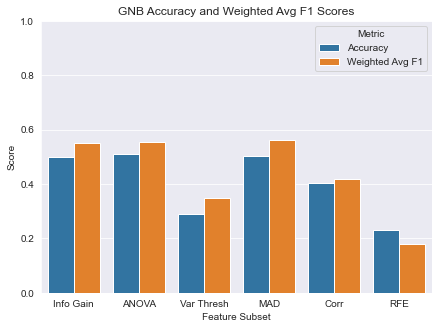

In [40]:
plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')
metric_chart = sns.barplot(x='Feature Subset', y='Score', hue='Metric', data=metric_df)
metric_chart.set_title('GNB Accuracy and Weighted Avg F1 Scores')
plt.ylim(ymax=1.0)
plt.savefig('./images/feat_subset_acc_f1.png', dpi=300, bbox_inches='tight')
plt.show()

With this model the feature subsets generated by Information Gain, ANOVA and MAD produce similar results, with MAD comiing out slightly ahead.  The results still aren't very good, though.  Let's try some more powerful models.

Let's try Naive Bayes on the set of features identified as most important by the Random Forest model.

In [ ]:
rfb3_sorted_importances = joblib.load('./data/rfb3_sorted_feature_importances.pkl')

In [ ]:
top_feats = [x[0] for x in rfb3_sorted_importances if x[1] > 1e-3]

In [ ]:
train_std_RF = training_data_std[top_feats].copy()
test_std_RF = testing_data_std[top_feats].copy()

In [72]:
gnb_RF = GaussianNB()
gnb_RF.fit(train_std_RF, y_train)

GaussianNB()

In [73]:
joblib.dump(gnb_RF, './data/gnb_model_RF.pkl')
#gnb_RF = joblib.load('./data/gnb_model_RF.pkl')

['./data/gnb_model_RF.pkl']

In [74]:
#y_pred_RF = gnb_RF.predict(test_std_RF)
y_pred_gnb_RF = cross_val_predict(gnb_RF, train_std_RF, y_train, cv=5, n_jobs=-1)  # save the test set for final models

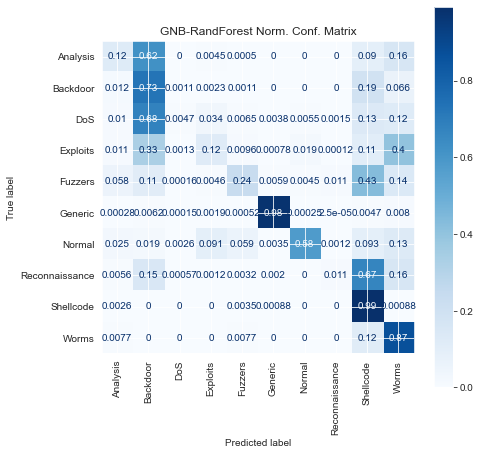

              precision    recall  f1-score   support

           0       0.08      0.13      0.10      2000
           1       0.05      0.72      0.09      1746
           2       0.25      0.01      0.01     12264
           3       0.39      0.12      0.18     33393
           4       0.53      0.24      0.33     18184
           5       0.99      0.98      0.98     40000
           6       0.98      0.57      0.72     56000
           7       0.19      0.01      0.02     10491
           8       0.04      0.99      0.08      1133
           9       0.00      0.84      0.01       130

    accuracy                           0.47    175341
   macro avg       0.35      0.46      0.25    175341
weighted avg       0.70      0.47      0.53    175341

0.46820196075076564


In [75]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_gnb_RF = confusion_matrix(y_train, y_pred_gnb_RF)
#print(con_mat_gnb_RF)
plt_norm_confmat(gnb_RF, train_std_RF, y_train, 'GNB-RandForest Norm. Conf. Matrix', 
                 fname='gnb_RF_conf_mat', labels=class_names)
plt.show()
class_rep_gnb_RF = classification_report(y_train, y_pred_gnb_RF)
rep_dict_gnb_RF = classification_report(y_train, y_pred_gnb_RF, output_dict=True)
print(class_rep_gnb_RF)
acc_gnb_RF = accuracy_score(y_train, y_pred_gnb_RF)
print(acc_gnb_RF)

In [76]:
joblib.dump(con_mat_gnb_RF, './data/con_mat_gnb_RF.pkl')

['./data/con_mat_gnb_RF.pkl']

In [77]:
joblib.dump(rep_dict_gnb_RF, './data/gnb_RF_class_rep.pkl')

['./data/gnb_RF_class_rep.pkl']

These aren't the best results on this model, but they're not the worst either.

## K-nearest neighbors

In [41]:
from sklearn.neighbors import KNeighborsClassifier

In [191]:
# start with default settings; k=5, distance=minkowski
knn_model = KNeighborsClassifier(n_jobs=-1)
knn_model.fit(train_std_ig, y_train)

KNeighborsClassifier(n_jobs=-1)

In [195]:
joblib.dump(knn_model, './data/knn_model_ig_5.pkl')
#knn_model = joblib.load('./data/knn_model_ig_5.pkl')

['./data/knn_model_ig_5.pkl']

In [193]:
# predict classes for the test set
#y_pred = knn_model.predict(test_std_ig)
y_pred_5nn_ig = cross_val_predict(knn_model, train_std_ig, y_train, cv=5, n_jobs=-1)  # save the test set for final models

Let's see how we did

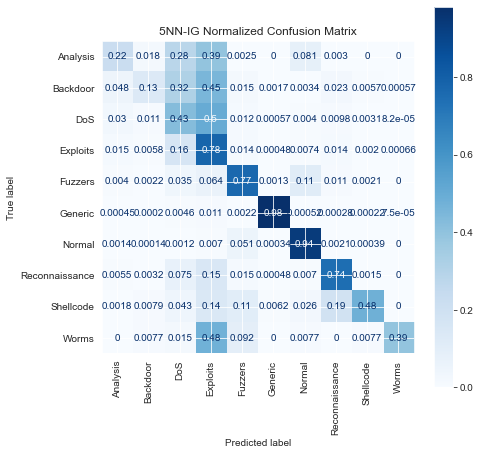

              precision    recall  f1-score   support

           0       0.11      0.12      0.12      2000
           1       0.15      0.09      0.11      1746
           2       0.33      0.45      0.38     12264
           3       0.65      0.67      0.66     33393
           4       0.55      0.63      0.58     18184
           5       0.98      0.98      0.98     40000
           6       0.90      0.81      0.85     56000
           7       0.79      0.70      0.75     10491
           8       0.44      0.33      0.38      1133
           9       0.44      0.27      0.33       130

    accuracy                           0.75    175341
   macro avg       0.54      0.51      0.51    175341
weighted avg       0.77      0.75      0.76    175341

0.7516895649049566


In [198]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat = confusion_matrix(y_train, y_pred_5nn_ig)
#print(con_mat)
plt_norm_confmat(knn_model, train_std_ig, y_train, '5NN-IG Normalized Confusion Matrix', 
                fname='5NN_ig_conf_mat', labels=class_names)
plt.show()
class_rep = classification_report(y_train, y_pred_5nn_ig)
rep_dict = classification_report(y_train, y_pred_5nn_ig, output_dict=True)
print(class_rep)
accuracy = accuracy_score(y_train, y_pred_5nn_ig)
print(accuracy)

75% accuracy & .76 f1-score (weighted avg) with 5 neighbors, on cross validation predictions.

In [105]:
joblib.dump(con_mat, './data/con_mat_5nn_ig.pkl')

['./data/con_mat_5nn_ig.pkl']

In [199]:
joblib.dump(rep_dict, './data/5NN_ig_class_rep.pkl')

['./data/5NN_ig_class_rep.pkl']

Next...

In [22]:
knn_model2 = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
knn_model2.fit(train_std_ig, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=7)

In [23]:
joblib.dump(knn_model2, './data/knn_model_ig_7.pkl')
#knn_model2 = joblib.load('./data/knn_model_ig_7.pkl')

['./data/knn_model_ig_7.pkl']

In [29]:
#y_pred2 = knn_model2.predict(test_std_ig)
y_pred_7nn_ig = cross_val_predict(knn_model2, train_std_ig, y_train, cv=5, n_jobs=-1)  # save the test set for final models

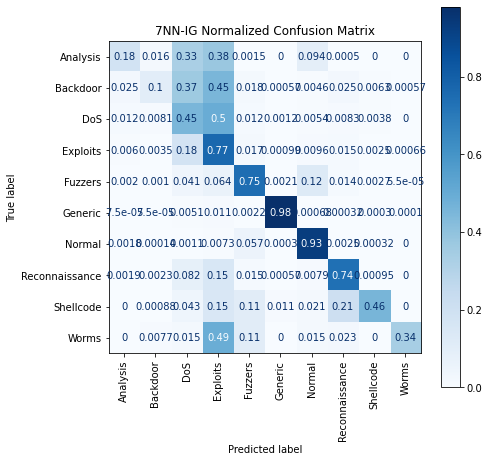

              precision    recall  f1-score   support

           0       0.10      0.08      0.09      2000
           1       0.22      0.07      0.10      1746
           2       0.33      0.44      0.38     12264
           3       0.64      0.69      0.66     33393
           4       0.55      0.63      0.59     18184
           5       0.99      0.98      0.98     40000
           6       0.90      0.81      0.85     56000
           7       0.79      0.70      0.75     10491
           8       0.46      0.33      0.38      1133
           9       0.45      0.23      0.31       130

    accuracy                           0.75    175341
   macro avg       0.54      0.50      0.51    175341
weighted avg       0.77      0.75      0.76    175341

0.7536913785138672


In [36]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_7nn_ig = confusion_matrix(y_train, y_pred_7nn_ig)
#print(con_mat)
plt_norm_confmat(knn_model2, train_std_ig, y_train, '7NN-IG Normalized Confusion Matrix', 
                 fname='7NN_ig_conf_mat', labels=class_names)
plt.show()
class_rep_7nn_ig = classification_report(y_train, y_pred_7nn_ig)
rep_dict_7nn_ig = classification_report(y_train, y_pred_7nn_ig, output_dict=True)
print(class_rep_7nn_ig)
acc2 = accuracy_score(y_train, y_pred_7nn_ig)
print(acc2)

75% accuracy & .76 f1-score with 7 neighbors, about the same...maybe fewer will work better? or maybe we need significantly more?

In [104]:
joblib.dump(con_mat_7nn_ig, './data/con_mat_7nn_ig.pkl')

['./data/con_mat_7nn_ig.pkl']

In [37]:
joblib.dump(rep_dict_7nn_ig, './data/7NN_ig_class_rep.pkl')

['./data/7NN_ig_class_rep.pkl']

Next...

In [38]:
knn_model3 = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn_model3.fit(train_std_ig, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

In [39]:
joblib.dump(knn_model3, './data/knn_model_ig_3.pkl')
#knn_model3 = joblib.load('./data/knn_model_ig_3.pkl')

['./data/knn_model_ig_3.pkl']

In [40]:
#y_pred3 = knn_model3.predict(test_std_ig)
y_pred_3nn_ig = cross_val_predict(knn_model3, train_std_ig, y_train, cv=5, n_jobs=-1)  # save the test set for final models

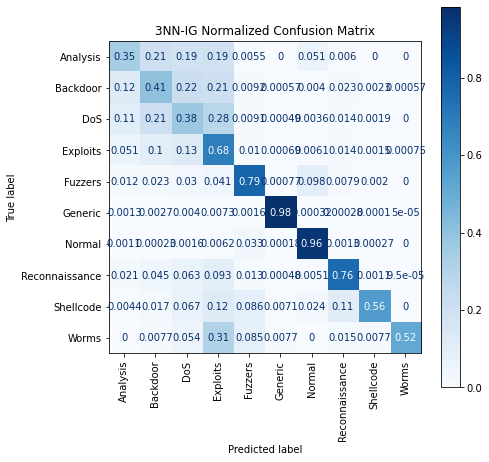

              precision    recall  f1-score   support

           0       0.08      0.20      0.11      2000
           1       0.07      0.24      0.11      1746
           2       0.31      0.34      0.32     12264
           3       0.68      0.61      0.64     33393
           4       0.55      0.60      0.57     18184
           5       0.98      0.98      0.98     40000
           6       0.89      0.81      0.85     56000
           7       0.80      0.70      0.75     10491
           8       0.49      0.36      0.41      1133
           9       0.45      0.30      0.36       130

    accuracy                           0.73    175341
   macro avg       0.53      0.51      0.51    175341
weighted avg       0.77      0.73      0.75    175341

0.7326238586525684


In [41]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_3nn_ig = confusion_matrix(y_train, y_pred_3nn_ig)
#print(con_mat)
plt_norm_confmat(knn_model3, train_std_ig, y_train, '3NN-IG Normalized Confusion Matrix', 
                 fname='3NN_ig_conf_mat', labels=class_names)
plt.show()
class_rep_3nn_ig = classification_report(y_train, y_pred_3nn_ig)
rep_dict_3nn_ig = classification_report(y_train, y_pred_3nn_ig, output_dict=True)
print(class_rep_3nn_ig)
acc3 = accuracy_score(y_train, y_pred_3nn_ig)
print(acc3)

73%  & .75 f1-score with 3 neighbors, still roughly the same. The confusion matrix looks a little better here.

In [106]:
con_mat_3nn_ig = confusion_matrix(y_train, y_pred_3nn_ig)

In [107]:
joblib.dump(con_mat_3nn_ig, './data/con_mat_3nn_ig.pkl')

['./data/con_mat_3nn_ig.pkl']

In [42]:
joblib.dump(rep_dict_3nn_ig, './data/3NN_ig_class_rep.pkl')

['./data/3NN_ig_class_rep.pkl']

Let's try one more, there are 10 classes to predict, let's try 11 neighbors

In [43]:
knn_model4 = KNeighborsClassifier(n_neighbors=11, n_jobs=-1)
knn_model4.fit(train_std_ig, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=11)

In [44]:
joblib.dump(knn_model4, './data/knn_model_ig_11.pkl')
#knn_model4 = joblib.load('./data/knn_model_ig_11.pkl')

['./data/knn_model_ig_11.pkl']

In [47]:
#y_pred4 = knn_model4.predict(test_std_ig)
y_pred_11nn_ig = cross_val_predict(knn_model4, train_std_ig, y_train, cv=5, n_jobs=-1)  # save the test set for final models

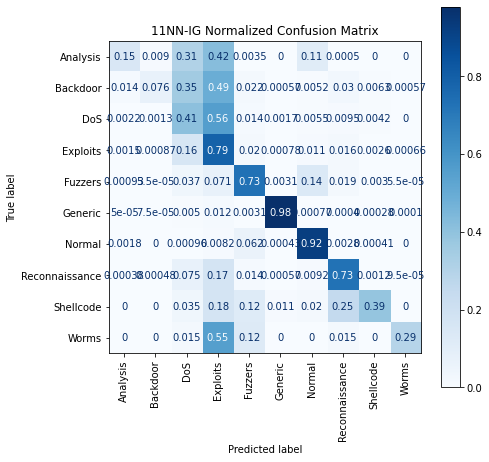

              precision    recall  f1-score   support

           0       0.11      0.06      0.08      2000
           1       0.31      0.05      0.09      1746
           2       0.32      0.41      0.36     12264
           3       0.63      0.71      0.67     33393
           4       0.56      0.64      0.59     18184
           5       0.98      0.98      0.98     40000
           6       0.90      0.80      0.85     56000
           7       0.78      0.71      0.74     10491
           8       0.48      0.32      0.38      1133
           9       0.38      0.19      0.26       130

    accuracy                           0.76    175341
   macro avg       0.54      0.49      0.50    175341
weighted avg       0.77      0.76      0.76    175341

0.7553795176256551


In [48]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_11nn_ig = confusion_matrix(y_train, y_pred_11nn_ig)
#print(con_mat)
plt_norm_confmat(knn_model4, train_std_ig, y_train, '11NN-IG Normalized Confusion Matrix', 
                 fname='11NN_ig_conf_mat', labels=class_names)
plt.show()
class_rep_11nn_ig = classification_report(y_train, y_pred_11nn_ig)
rep_dict_11nn_ig = classification_report(y_train, y_pred_11nn_ig, output_dict=True)
print(class_rep_11nn_ig)
acc4 = accuracy_score(y_train, y_pred_11nn_ig)
print(acc4)

75% accuracy & .76 f1-score, again no real change
The chosen features and number of neighbors doesn't seem to produce much difference with this model.

In [101]:
joblib.dump(con_mat_11nn_ig, './data/con_mat_11nn_ig.pkl')

['./data/con_mat_11nn_ig.pkl']

In [49]:
joblib.dump(rep_dict_11nn_ig, './data/11NN_ig_class_rep.pkl')

['./data/11NN_ig_class_rep.pkl']

Checking the results shows where the misclassificatons are happening most often:  
- Normal, ok  
- Generic, ok  
- Exploits, ok, highest misclass=DoS  
- Fuzzers, highest misclass=Normal  
- DoS, not ok, highest misclass=Exploits  
- Reconnaissance, not great, highest misclass=Exploits  
- Analysis, poor, highest misclass=Exploits, DoS  
- Backdoor, poor, highest miclass=Exploits  
- Shellcode, poor, highest misclass=Exploits, Fuzzers  
- Worms, poor, highest misclass=Exploits  

This is probably due to the relatively small number of some attack categories.  Those classes are often misclassified as *Exploits*.

### Let's try it with GridSeachCV

In [42]:
from sklearn.model_selection import GridSearchCV

https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657  
https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/

In [51]:
# since I've already run several tests using minkowski distance I'll leave those out, even though they weren't CV'd
params = {'n_neighbors':[5, 11, 19], 'weights':['uniform', 'distance'], 'metric':['euclidean', 'manhattan']}
knn_gs = GridSearchCV(KNeighborsClassifier(), params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

In [52]:
knn_gs_results = knn_gs.fit(train_std_ig, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [53]:
print(knn_gs_results.best_score_)
print(knn_gs_results.best_estimator_)
print(knn_gs_results.best_params_)

0.7499329877210692
KNeighborsClassifier(metric='manhattan', n_neighbors=11)
{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}


75% accuracy looks decent, considering this isn't a very powerful model.

Let's see all of the results

In [54]:
results = knn_gs_results.cv_results_
results_df = pd.DataFrame(results)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.081551,0.017656,554.543982,3.736889,euclidean,5,uniform,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.792684,0.806303,0.629014,0.742667,0.080557,11
1,0.102438,0.024379,562.067632,5.200711,euclidean,5,distance,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.791965,0.807775,0.623591,0.741110,0.083349,12
2,0.168483,0.006953,609.806760,4.096366,euclidean,11,uniform,"{'metric': 'euclidean', 'n_neighbors': 11, 'we...",0.796602,0.808733,0.632436,0.745924,0.080400,6
3,0.157367,0.015479,609.054046,4.773002,euclidean,11,distance,"{'metric': 'euclidean', 'n_neighbors': 11, 'we...",0.797663,0.810752,0.624840,0.744418,0.084723,9
4,0.222680,0.117742,607.421384,6.270198,euclidean,19,uniform,"{'metric': 'euclidean', 'n_neighbors': 19, 'we...",0.796055,0.809468,0.629117,0.744880,0.082040,7
5,0.150805,0.034105,601.898392,5.412225,euclidean,19,distance,"{'metric': 'euclidean', 'n_neighbors': 19, 'we...",0.797902,0.810854,0.624224,0.744327,0.085090,10
6,0.136489,0.056444,782.575531,5.151420,manhattan,5,uniform,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.798553,0.807398,0.634917,0.746956,0.079306,5
7,0.108316,0.009047,773.627447,4.178288,manhattan,5,distance,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.797560,0.807244,0.628638,0.744481,0.082009,8
8,0.107996,0.011946,777.261737,2.587637,manhattan,11,uniform,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...",0.804370,0.810478,0.634951,0.749933,0.081343,1
9,0.092448,0.002128,773.080283,7.437940,manhattan,11,distance,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...",0.805191,0.812394,0.628313,0.748633,0.085130,4


Let's save this for later.

In [55]:
joblib.dump(knn_gs, './data/knn_grid_search.pkl')
#knn_gs = joblib.load('./data/knn_grid_search.pkl')
joblib.dump(knn_gs_results, './data/knn_gs_results.pkl')
#knn_gs_results = joblib.load('./data/knn_gs_results.pkl')

['./data/knn_gs_results.pkl']

Let's train a model with the 'best' parameters...

In [56]:
knn_model_best = KNeighborsClassifier(n_neighbors=11, weights='uniform', metric='manhattan', n_jobs=-1)
knn_model_best.fit(train_std_ig, y_train)

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=11)

In [57]:
joblib.dump(knn_model_best, './data/knn_model_best_ig.pkl')
#knn_model_best = joblib.load('./data/knn_model_best_ig.pkl')

['./data/knn_model_best_ig.pkl']

In [59]:
#y_pred_best = knn_model_best.predict(test_std_ig)
y_pred_best = cross_val_predict(knn_model_best, train_std_ig, y_train, cv=5, n_jobs=-1)  # save the test set for final models

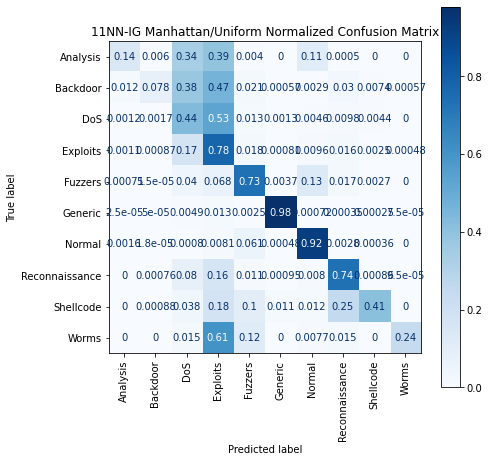

              precision    recall  f1-score   support

           0       0.12      0.07      0.09      2000
           1       0.51      0.06      0.10      1746
           2       0.32      0.41      0.36     12264
           3       0.64      0.72      0.68     33393
           4       0.57      0.64      0.60     18184
           5       0.98      0.98      0.98     40000
           6       0.90      0.81      0.85     56000
           7       0.79      0.72      0.75     10491
           8       0.51      0.34      0.41      1133
           9       0.44      0.13      0.20       130

    accuracy                           0.76    175341
   macro avg       0.58      0.49      0.50    175341
weighted avg       0.77      0.76      0.76    175341

0.7589382973748297


In [60]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_best = confusion_matrix(y_train, y_pred_best)
#print(con_mat_best)
plt_norm_confmat(knn_model_best, train_std_ig, y_train, '11NN-IG Manhattan/Uniform Normalized Confusion Matrix', 
                 fname='knn_best_ig_conf_mat', labels=class_names)
plt.show()
class_rep_best = classification_report(y_train, y_pred_best)
rep_dict_best = classification_report(y_train, y_pred_best, output_dict=True)
print(class_rep_best)
acc_best = accuracy_score(y_train, y_pred_best)
print(acc_best)

In [100]:
joblib.dump(con_mat_best, './data/con_mat_knn_best_ig.pkl')

['./data/con_mat_knn_best_ig.pkl']

In [61]:
joblib.dump(rep_dict_best, './data/best_11NN_ig_class_rep.pkl')

['./data/best_11NN_ig_class_rep.pkl']

Our best model achieved 71% on the Test Set.  Not too bad.

#### We should try the other feature sets.

In [62]:
knn_model_best_anova = KNeighborsClassifier(n_neighbors=11, weights='uniform', metric='manhattan', n_jobs=-1)
knn_model_best_anova.fit(train_std_anova, y_train)

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=11)

In [63]:
joblib.dump(knn_model_best_anova, './data/knn_model_best_anova.pkl')
#knn_model_best_anova = joblib.load('./data/knn_model_best_anova.pkl')

['./data/knn_model_best_anova.pkl']

In [72]:
#y_pred_best_anova = knn_model_best_anova.predict(test_std_anova)
y_pred_best_anova = cross_val_predict(knn_model_best_anova, train_std_anova, y_train, cv=5, n_jobs=-1)  # save the test set for final models

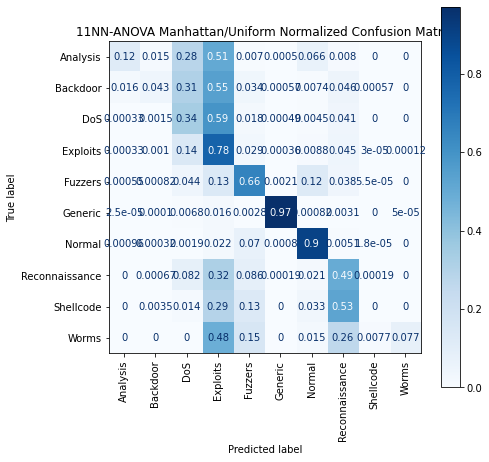

              precision    recall  f1-score   support

           0       0.15      0.04      0.06      2000
           1       0.07      0.01      0.02      1746
           2       0.30      0.35      0.32     12264
           3       0.53      0.64      0.58     33393
           4       0.44      0.53      0.48     18184
           5       0.96      0.97      0.96     40000
           6       0.89      0.76      0.82     56000
           7       0.46      0.43      0.45     10491
           8       0.10      0.01      0.01      1133
           9       0.64      0.07      0.13       130

    accuracy                           0.69    175341
   macro avg       0.45      0.38      0.38    175341
weighted avg       0.70      0.69      0.69    175341

0.6898899857991


In [73]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_best_anova = confusion_matrix(y_train, y_pred_best_anova)
#print(con_mat_best_anova)
plt_norm_confmat(knn_model_best_anova, train_std_anova, y_train, '11NN-ANOVA Manhattan/Uniform Normalized Confusion Matrix', 
                 fname='knn_best_anova_conf_mat', labels=class_names)
plt.show()
class_rep_best_anova = classification_report(y_train, y_pred_best_anova)
rep_dict_best_anova = classification_report(y_train, y_pred_best_anova, output_dict=True)
print(class_rep_best_anova)
acc_best_best_anova = accuracy_score(y_train, y_pred_best_anova)
print(acc_best_best_anova)

In [99]:
joblib.dump(con_mat_best_anova, './data/con_mat_knn_best_anova.pkl')

['./data/con_mat_knn_best_anova.pkl']

In [74]:
joblib.dump(rep_dict_best_anova, './data/best_anova_class_rep.pkl')

['./data/best_anova_class_rep.pkl']

Next...

In [67]:
knn_model_best_vt = KNeighborsClassifier(n_neighbors=11, weights='uniform', metric='manhattan', n_jobs=-1)
knn_model_best_vt.fit(train_std_vt, y_train)

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=11)

In [68]:
joblib.dump(knn_model_best_vt, './data/knn_model_best_vt.pkl')
#knn_model_best_vt = joblib.load('./data/knn_model_best_vt.pkl')

['./data/knn_model_best_vt.pkl']

In [69]:
#y_pred_best_vt = knn_model_best_vt.predict(test_std_vt)
y_pred_best_vt = cross_val_predict(knn_model_best_vt, train_std_vt, y_train, cv=5, n_jobs=-1)  # save the test set for final models

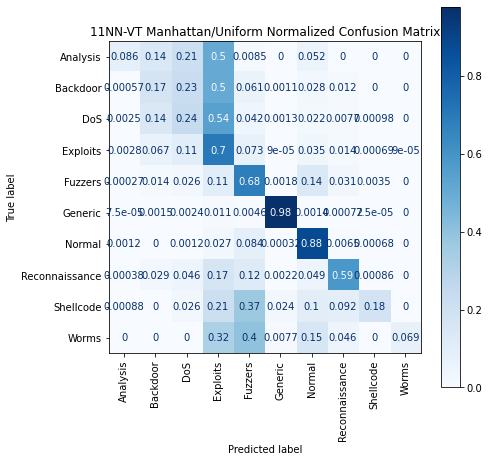

              precision    recall  f1-score   support

           0       0.12      0.07      0.09      2000
           1       0.51      0.06      0.10      1746
           2       0.32      0.41      0.36     12264
           3       0.64      0.72      0.68     33393
           4       0.57      0.64      0.60     18184
           5       0.98      0.98      0.98     40000
           6       0.90      0.81      0.85     56000
           7       0.79      0.72      0.75     10491
           8       0.51      0.34      0.41      1133
           9       0.44      0.13      0.20       130

    accuracy                           0.76    175341
   macro avg       0.58      0.49      0.50    175341
weighted avg       0.77      0.76      0.76    175341

0.7589382973748297


In [70]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_best_vt = confusion_matrix(y_train, y_pred_best_vt)
#print(con_mat_best_vt)
plt_norm_confmat(knn_model_best_vt, train_std_vt, y_train, '11NN-VT Manhattan/Uniform Normalized Confusion Matrix', 
                 fname='knn_best_vt_conf_mat', labels=class_names)
plt.show()
class_rep_best_vt = classification_report(y_train, y_pred_best_vt)
rep_dict_best_vt = classification_report(y_train, y_pred_best_vt, output_dict=True)
print(class_rep_best_vt)
acc_best_best_vt = accuracy_score(y_train, y_pred_best_vt)
print(acc_best_best_vt)

In [98]:
joblib.dump(con_mat_best_vt, './data/con_mat_knn_best_vt.pkl')

['./data/con_mat_knn_best_vt.pkl']

In [71]:
joblib.dump(rep_dict_best_vt, './data/best_vt_class_rep.pkl')

['./data/best_vt_class_rep.pkl']

Next...

In [75]:
knn_model_best_mad = KNeighborsClassifier(n_neighbors=11, weights='uniform', metric='manhattan', n_jobs=-1)
knn_model_best_mad.fit(train_std_mad, y_train)

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=11)

In [76]:
joblib.dump(knn_model_best_mad, './data/knn_model_best_mad.pkl')
#knn_model_best_mad = joblib.load('./data/knn_model_best_mad.pkl')

['./data/knn_model_best_mad.pkl']

In [77]:
#y_pred_best_mad = knn_model_best.predict(test_std_mad)
y_pred_best_mad = cross_val_predict(knn_model_best_mad, train_std_mad, y_train, cv=5, n_jobs=-1)  # save the test set for final models

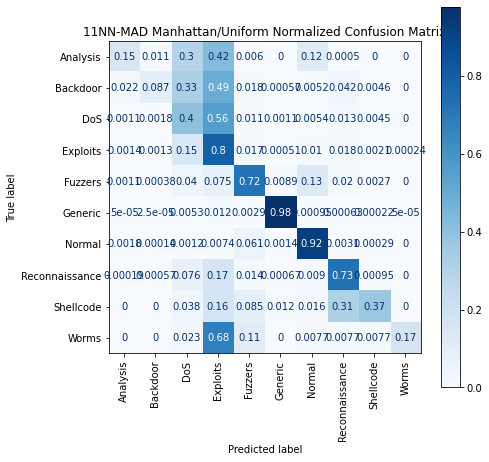

              precision    recall  f1-score   support

           0       0.13      0.08      0.10      2000
           1       0.27      0.06      0.09      1746
           2       0.32      0.43      0.36     12264
           3       0.64      0.70      0.67     33393
           4       0.56      0.62      0.59     18184
           5       0.97      0.98      0.97     40000
           6       0.90      0.80      0.85     56000
           7       0.76      0.71      0.73     10491
           8       0.52      0.31      0.39      1133
           9       0.43      0.09      0.15       130

    accuracy                           0.75    175341
   macro avg       0.55      0.48      0.49    175341
weighted avg       0.76      0.75      0.76    175341

0.7527788708858738


In [78]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_best_mad = confusion_matrix(y_train, y_pred_best_mad)
#print(con_mat_best_mad)
plt_norm_confmat(knn_model_best_mad, train_std_mad, y_train, '11NN-MAD Manhattan/Uniform Normalized Confusion Matrix', 
                 fname='knn_best_mad_conf_mat', labels=class_names)
plt.show()
class_rep_best_mad = classification_report(y_train, y_pred_best_mad)
rep_dict_best_mad = classification_report(y_train, y_pred_best_mad, output_dict=True)
print(class_rep_best_mad)
acc_best_best_mad = accuracy_score(y_train, y_pred_best_mad)
print(acc_best_best_mad)

In [97]:
joblib.dump(con_mat_best_mad, './data/con_mat_knn_best_mad.pkl')

['./data/con_mat_knn_best_mad.pkl']

In [79]:
joblib.dump(rep_dict_best_mad, './data/best_mad_class_rep.pkl')

['./data/best_mad_class_rep.pkl']

Next...

In [80]:
knn_model_best_corr = KNeighborsClassifier(n_neighbors=11, weights='uniform', metric='manhattan', n_jobs=-1)
knn_model_best_corr.fit(train_std_corr, y_train)

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=11)

In [81]:
joblib.dump(knn_model_best_corr, './data/knn_model_best_corr.pkl')
#knn_model_best_corr = joblib.load('./data/knn_model_best_corr.pkl')

['./data/knn_model_best_corr.pkl']

In [82]:
#y_pred_best_corr = knn_model_best_corr.predict(test_std_corr)
y_pred_best_corr = cross_val_predict(knn_model_best_corr, train_std_corr, y_train, cv=5, n_jobs=-1)  # save the test set for final models

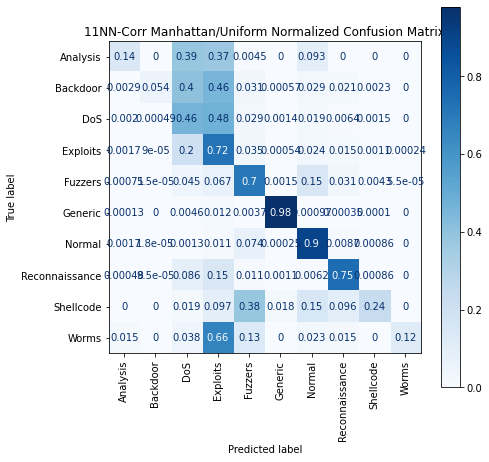

              precision    recall  f1-score   support

           0       0.20      0.09      0.13      2000
           1       0.28      0.04      0.07      1746
           2       0.33      0.35      0.34     12264
           3       0.61      0.72      0.66     33393
           4       0.54      0.64      0.58     18184
           5       0.99      0.98      0.99     40000
           6       0.89      0.80      0.84     56000
           7       0.77      0.73      0.75     10491
           8       0.44      0.19      0.26      1133
           9       0.42      0.04      0.07       130

    accuracy                           0.75    175341
   macro avg       0.55      0.46      0.47    175341
weighted avg       0.76      0.75      0.75    175341

0.7531552802824211


In [83]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_best_corr = confusion_matrix(y_train, y_pred_best_corr)
#print(con_mat_best_corr)
plt_norm_confmat(knn_model_best_corr, train_std_corr, y_train, '11NN-Corr Manhattan/Uniform Normalized Confusion Matrix', 
                 fname='knn_best_corr_conf_mat', labels=class_names)
plt.show()
class_rep_best_corr = classification_report(y_train, y_pred_best_corr)
rep_dict_best_corr = classification_report(y_train, y_pred_best_corr, output_dict=True)
print(class_rep_best_corr)
acc_best_best_corr = accuracy_score(y_train, y_pred_best_corr)
print(acc_best_best_corr)

In [96]:
joblib.dump(con_mat_best_corr, './data/con_mat_knn_best_corr.pkl')

['./data/con_mat_knn_best_corr.pkl']

In [84]:
joblib.dump(rep_dict_best_corr, './data/best_corr_class_rep.pkl')

['./data/best_corr_class_rep.pkl']

OK, from these feature subsets only the set of ANOVA features seem to perform significantly differently from the Info Gain set.  
76% accuracy & .76 f1-score on the cross validation predictions using the top 20 Info Gain features.  
69% accuracy  & .69 f1-score on the cross validation predictions using the top 20 ANOVA features.  
All other feature subsets perform similarly to the Info Gain features on this model with these parameters.  
Should the hyperparameters be tuned for each feature subset, or is it OK to use the parameters found using the Info Gain set?

What about the RFECV feature set?

In [85]:
knn_model_best_rfe = KNeighborsClassifier(n_neighbors=11, weights='uniform', metric='manhattan', n_jobs=-1)
knn_model_best_rfe.fit(train_std_rfe, y_train)

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=11)

In [86]:
joblib.dump(knn_model_best_rfe, './data/knn_model_best_rfe.pkl')
#knn_model_best_rfe = joblib.load('./data/knn_model_best_rfe.pkl')

['./data/knn_model_best_rfe.pkl']

In [87]:
#y_pred_rfe = knn_model_rfe.predict(test_std_rfe)
y_pred_best_rfe = cross_val_predict(knn_model_best_rfe, train_std_rfe, y_train, cv=5, n_jobs=-1)  # save the test set for final models

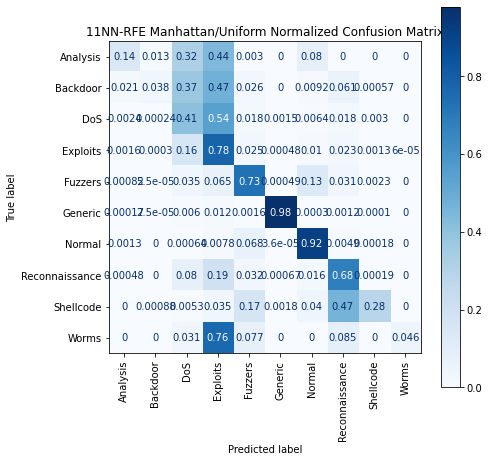

ValueError: Found input variables with inconsistent numbers of samples: [82332, 175341]

In [88]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_rfe = confusion_matrix(y_train, y_pred_best_rfe)
#print(con_mat_rfe)
plt_norm_confmat(knn_model_best_rfe, train_std_rfe, y_train, '11NN-RFE Manhattan/Uniform Normalized Confusion Matrix', 
                 fname='knn_best_rfe_conf_mat', labels=class_names)
plt.show()
class_rep_best_rfe = classification_report(y_train, y_pred_best_rfe)
rep_dict_best_rfe = classification_report(y_train, y_pred_best_rfe, output_dict=True)
print(class_rep_best_rfe)
acc_best_rfe = accuracy_score(y_train, y_pred_best_rfe)
print(acc_best_rfe)

Accidentally passed the wrong set to the `classification_report` function -- run it below so I don't need to re-run the plot.

In [89]:
class_rep_best_rfe = classification_report(y_train, y_pred_best_rfe)
rep_dict_best_rfe = classification_report(y_train, y_pred_best_rfe, output_dict=True)
print(class_rep_best_rfe)
acc_best_rfe = accuracy_score(y_train, y_pred_best_rfe)
print(acc_best_rfe)

              precision    recall  f1-score   support

           0       0.23      0.08      0.12      2000
           1       0.17      0.02      0.03      1746
           2       0.31      0.42      0.36     12264
           3       0.63      0.69      0.66     33393
           4       0.52      0.63      0.57     18184
           5       1.00      0.98      0.99     40000
           6       0.90      0.80      0.85     56000
           7       0.68      0.64      0.66     10491
           8       0.61      0.23      0.33      1133
           9       0.50      0.01      0.02       130

    accuracy                           0.75    175341
   macro avg       0.56      0.45      0.46    175341
weighted avg       0.76      0.75      0.75    175341

0.7465681158428433


In [95]:
joblib.dump(con_mat_rfe, './data/con_mat_knn_best_rfe.pkl')

['./data/con_mat_knn_best_rfe.pkl']

In [90]:
joblib.dump(rep_dict_best_rfe, './data/best_rfe_class_rep.pkl')

['./data/best_rfe_class_rep.pkl']

In [43]:
rep_dict_best = joblib.load('./data/best_11NN_ig_class_rep.pkl')
rep_dict_best_anova = joblib.load('./data/best_anova_class_rep.pkl')
rep_dict_best_vt = joblib.load('./data/best_vt_class_rep.pkl')
rep_dict_best_mad = joblib.load('./data/best_mad_class_rep.pkl')
rep_dict_best_corr = joblib.load('./data/best_corr_class_rep.pkl')
rep_dict_best_rfe = joblib.load('./data/best_rfe_class_rep.pkl')

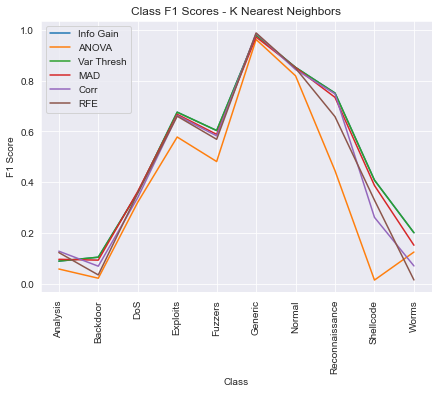

In [92]:
knn_reports = [rep_dict_best, rep_dict_best_anova, rep_dict_best_vt, rep_dict_best_mad, rep_dict_best_corr, rep_dict_best_rfe]
knn_lgnds = ['Info Gain', 'ANOVA', 'Var Thresh', 'MAD', 'Corr', 'RFE']
labels = ['0', '1', '2', '3','4', '5', '6', '7', '8', '9']
fig, ax = plt.subplots(figsize=(7, 5))
sns.set_style('darkgrid')

for report, lgnd in zip(knn_reports, knn_lgnds):
    f1_scores = []
    for lab in labels:
        f1_scores.append(report[lab]['f1-score'])
    sns.lineplot(x=label_encoder.classes_, y=f1_scores, label=lgnd)
plt.xlabel('Class')
plt.xticks(rotation=90, horizontalalignment='center')
plt.ylabel('F1 Score')
plt.title('Class F1 Scores - K Nearest Neighbors')
plt.legend()
plt.savefig('./images/class_f1s_knn_best.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# let's grab come metrics so we can plot them togther
knn_f1_acc = [('Accuracy', 'Info Gain', rep_dict_best['accuracy']),
          ('Accuracy', 'ANOVA', rep_dict_best_anova['accuracy']),
          ('Accuracy', 'Var Thresh', rep_dict_best_vt['accuracy']),
          ('Accuracy', 'MAD', rep_dict_best_mad['accuracy']),
          ('Accuracy', 'Corr', rep_dict_best_corr['accuracy']),
          ('Accuracy', 'RFE', rep_dict_best_rfe['accuracy']),
          ('Weighted Avg F1', 'Info Gain', rep_dict_best['weighted avg']['f1-score']),
          ('Weighted Avg F1', 'ANOVA', rep_dict_best_anova['weighted avg']['f1-score']),
          ('Weighted Avg F1', 'Var Thresh', rep_dict_best_vt['weighted avg']['f1-score']),
          ('Weighted Avg F1', 'MAD', rep_dict_best_mad['weighted avg']['f1-score']),
          ('Weighted Avg F1', 'Corr', rep_dict_best_corr['weighted avg']['f1-score']),
          ('Weighted Avg F1', 'RFE', rep_dict_best_rfe['weighted avg']['f1-score'])]
knn_metric_df = pd.DataFrame(knn_f1_acc, columns=['Metric', 'Feature Subset', 'Score'])

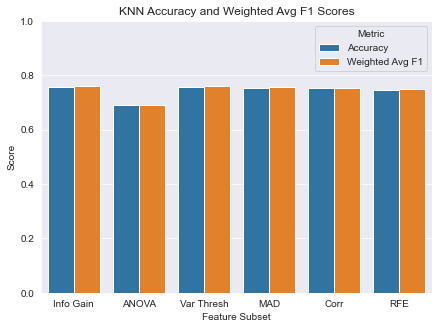

In [15]:
plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')
knn_metric_chart = sns.barplot(x='Feature Subset', y='Score', hue='Metric', data=knn_metric_df)
knn_metric_chart.set_title('KNN Accuracy and Weighted Avg F1 Scores')
plt.ylim(ymax=1.0)
plt.savefig('./images/feat_subset_acc_f1_knn.png', dpi=300, bbox_inches='tight')
plt.show()

Let's consider testing the most important features identified by the RandomForest classifier.  
1e-3 seems like a good cut-off, which will give us the top 50 features.

In [55]:
rfb3_sorted_importances = joblib.load('./data/rfb3_sorted_feature_importances.pkl')

In [56]:
top_feats = [x[0] for x in rfb3_sorted_importances if x[1] > 1e-3]

In [57]:
train_std_RF = training_data_std[top_feats].copy()
test_std_RF = testing_data_std[top_feats].copy()

In [64]:
knn_model_best_RF = KNeighborsClassifier(n_neighbors=11, weights='uniform', metric='manhattan', n_jobs=-1)
knn_model_best_RF.fit(train_std_RF, y_train)

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=11)

In [65]:
joblib.dump(knn_model_best_RF, './data/knn_model_best_RF.pkl')
#knn_model_best_RF = joblib.load('./data/knn_model_best_RF.pkl')

['./data/knn_model_best_RF.pkl']

In [66]:
#y_pred_RF = knn_model_RF.predict(test_std_RF)
y_pred_best_RF = cross_val_predict(knn_model_best_RF, train_std_RF, y_train, cv=5, n_jobs=-1)  # save the test set for final models

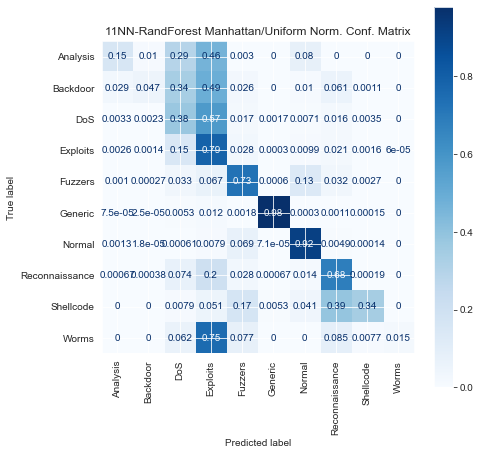

              precision    recall  f1-score   support

           0       0.24      0.08      0.12      2000
           1       0.14      0.02      0.04      1746
           2       0.31      0.44      0.36     12264
           3       0.63      0.68      0.65     33393
           4       0.54      0.63      0.58     18184
           5       1.00      0.98      0.99     40000
           6       0.90      0.80      0.85     56000
           7       0.70      0.64      0.67     10491
           8       0.63      0.28      0.39      1133
           9       0.00      0.00      0.00       130

    accuracy                           0.75    175341
   macro avg       0.51      0.45      0.46    175341
weighted avg       0.76      0.75      0.75    175341

0.746071939820122


In [67]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_RF = confusion_matrix(y_train, y_pred_best_RF)
#print(con_mat_RF)
plt_norm_confmat(knn_model_best_RF, train_std_RF, y_train, '11NN-RandForest Manhattan/Uniform Norm. Conf. Matrix', 
                 fname='knn_best_RF_conf_mat', labels=class_names)
plt.show()
class_rep_best_RF = classification_report(y_train, y_pred_best_RF)
rep_dict_best_RF = classification_report(y_train, y_pred_best_RF, output_dict=True)
print(class_rep_best_RF)
acc_best_RF = accuracy_score(y_train, y_pred_best_RF)
print(acc_best_RF)

In [68]:
joblib.dump(con_mat_RF, './data/con_mat_knn_best_RF.pkl')

['./data/con_mat_knn_best_RF.pkl']

In [69]:
joblib.dump(rep_dict_best_RF, './data/best_RF_class_rep.pkl')

['./data/best_RF_class_rep.pkl']

These results look comparable to those using the other feature subsets.  The model does well on those classes that are well represented, but poorly on those that are under-represented.  That is not unexpected.

## Model Evaluation

### Naive Bayes

In [19]:
gnb_ig_final = joblib.load('./data/gnb_model_ig.pkl')
gnb_anova_final = joblib.load('./data/gnb_model_anova.pkl')
gnb_vt_final = joblib.load('./data/gnb_model_vt.pkl')
gnb_mad_final = joblib.load('./data/gnb_model_mad.pkl')
gnb_corr_final = joblib.load('./data/gnb_model_corr.pkl')
gnb_RF_final = joblib.load('./data/gnb_model_RF.pkl')

#### Info Gain features

In [25]:
y_pred_final_gnb_ig = gnb_ig_final.predict(test_std_ig)

In [29]:
final_conf_mat_gnb_ig, final_class_rep_gnb_ig, final_rep_dict_gnb_ig, final_acc_gnb_ig = gen_metrics(y_test, y_pred_final_gnb_ig)
print(final_class_rep_gnb_ig)

              precision    recall  f1-score   support

           0       0.03      0.00      0.00       677
           1       0.02      0.47      0.03       583
           2       0.39      0.01      0.02      4089
           3       0.38      0.45      0.41     11132
           4       0.23      0.24      0.23      6062
           5       0.86      0.73      0.79     18871
           6       0.96      0.39      0.56     37000
           7       0.19      0.83      0.32      3496
           8       0.00      0.00      0.00       378
           9       0.02      0.14      0.03        44

    accuracy                           0.46     82332
   macro avg       0.31      0.33      0.24     82332
weighted avg       0.72      0.46      0.52     82332



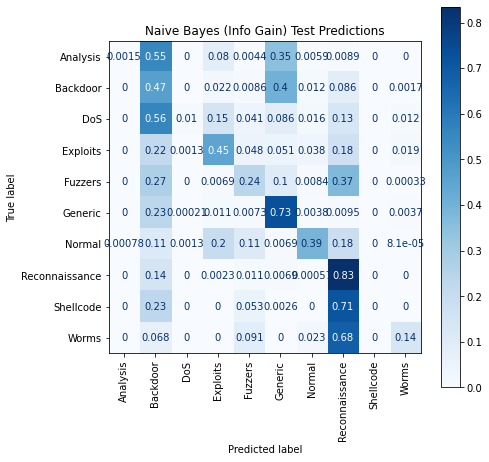

In [33]:
plt_norm_confmat(gnb_ig_final, test_std_ig, y_test, 'Naive Bayes (Info Gain) Test Predictions', 
                 fname='final_gnb_ig_conf_mat', labels=class_names)

In [31]:
joblib.dump(final_rep_dict_gnb_ig, 'final_rep_dict_gnb_ig.pkl')

['final_rep_dict_gnb_ig.pkl']

In [32]:
joblib.dump(final_conf_mat_gnb_ig, 'final_conf_mat_gnb_ig.pkl')

['final_conf_mat_gnb_ig.pkl']

#### ANOVA features

In [34]:
y_pred_final_gnb_anova = gnb_anova_final.predict(test_std_anova)

In [35]:
final_conf_mat_gnb_anova, final_class_rep_gnb_anova, final_rep_dict_gnb_anova, final_acc_gnb_anova = gen_metrics(y_test, y_pred_final_gnb_anova)
print(final_class_rep_gnb_anova)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.01      0.20      0.02       583
           2       0.12      0.05      0.07      4089
           3       0.41      0.45      0.43     11132
           4       0.28      0.30      0.29      6062
           5       0.76      0.83      0.79     18871
           6       0.96      0.41      0.57     37000
           7       0.18      0.79      0.29      3496
           8       0.00      0.00      0.00       378
           9       0.02      0.11      0.04        44

    accuracy                           0.50     82332
   macro avg       0.27      0.32      0.25     82332
weighted avg       0.69      0.50      0.54     82332



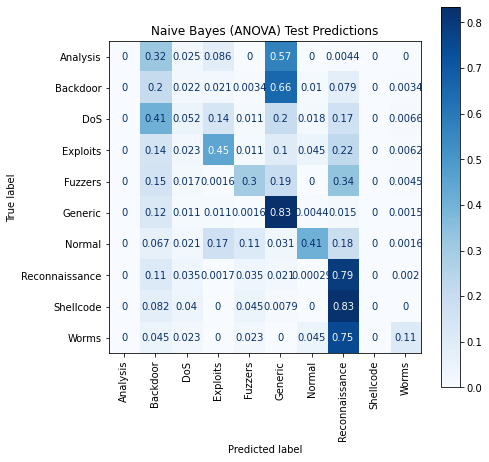

In [36]:
plt_norm_confmat(gnb_anova_final, test_std_anova, y_test, 'Naive Bayes (ANOVA) Test Predictions', 
                 fname='final_gnb_anova_conf_mat', labels=class_names)

In [37]:
joblib.dump(final_rep_dict_gnb_anova, 'final_rep_dict_gnb_anova.pkl')

['final_rep_dict_gnb_anova.pkl']

In [38]:
joblib.dump(final_conf_mat_gnb_anova, 'final_conf_mat_gnb_anova.pkl')

['final_conf_mat_gnb_anova.pkl']

#### Variance Threshold features

In [39]:
y_pred_final_gnb_vt = gnb_vt_final.predict(test_std_vt)

In [40]:
final_conf_mat_gnb_vt, final_class_rep_gnb_vt, final_rep_dict_gnb_vt, final_acc_gnb_vt = gen_metrics(y_test, y_pred_final_gnb_vt)
print(final_class_rep_gnb_vt)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.01      0.08      0.02       583
           2       0.08      0.01      0.01      4089
           3       0.43      0.37      0.40     11132
           4       0.24      0.14      0.18      6062
           5       0.60      0.97      0.74     18871
           6       0.92      0.45      0.60     37000
           7       0.12      0.52      0.19      3496
           8       0.00      0.00      0.00       378
           9       0.02      0.16      0.03        44

    accuracy                           0.51     82332
   macro avg       0.24      0.27      0.22     82332
weighted avg       0.64      0.51      0.52     82332



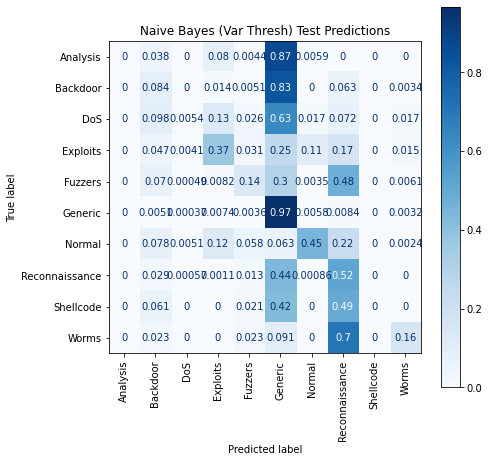

In [41]:
plt_norm_confmat(gnb_vt_final, test_std_vt, y_test, 'Naive Bayes (Var Thresh) Test Predictions', 
                 fname='final_gnb_vt_conf_mat', labels=class_names)

In [42]:
joblib.dump(final_rep_dict_gnb_vt, 'final_rep_dict_gnb_vt.pkl')

['final_rep_dict_gnb_vt.pkl']

In [43]:
joblib.dump(final_conf_mat_gnb_vt, 'final_conf_mat_gnb_vt.pkl')

['final_conf_mat_gnb_vt.pkl']

#### Median Absolute Deviation features

In [44]:
y_pred_final_gnb_mad = gnb_mad_final.predict(test_std_mad)

In [45]:
final_conf_mat_gnb_mad, final_class_rep_gnb_mad, final_rep_dict_gnb_mad, final_acc_gnb_mad = gen_metrics(y_test, y_pred_final_gnb_mad)
print(final_class_rep_gnb_mad)

              precision    recall  f1-score   support

           0       0.03      0.00      0.00       677
           1       0.02      0.45      0.03       583
           2       0.29      0.01      0.02      4089
           3       0.46      0.43      0.45     11132
           4       0.23      0.23      0.23      6062
           5       0.84      0.74      0.79     18871
           6       0.95      0.44      0.60     37000
           7       0.19      0.80      0.31      3496
           8       0.00      0.00      0.00       378
           9       0.01      0.18      0.02        44

    accuracy                           0.48     82332
   macro avg       0.30      0.33      0.25     82332
weighted avg       0.72      0.48      0.54     82332



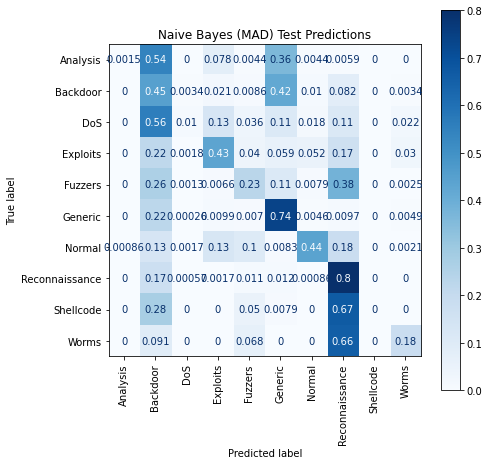

In [46]:
plt_norm_confmat(gnb_mad_final, test_std_mad, y_test, 'Naive Bayes (MAD) Test Predictions', 
                 fname='final_gnb_mad_conf_mat', labels=class_names)

In [47]:
joblib.dump(final_rep_dict_gnb_mad, 'final_rep_dict_gnb_mad.pkl')

['final_rep_dict_gnb_mad.pkl']

In [48]:
joblib.dump(final_conf_mat_gnb_mad, 'final_conf_mat_gnb_mad.pkl')

['final_conf_mat_gnb_mad.pkl']

#### Correlation features

In [49]:
y_pred_final_gnb_corr = gnb_corr_final.predict(test_std_corr)

In [50]:
final_conf_mat_gnb_corr, final_class_rep_gnb_corr, final_rep_dict_gnb_corr, final_acc_gnb_corr = gen_metrics(y_test, y_pred_final_gnb_corr)
print(final_class_rep_gnb_corr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.00      0.00      0.00       583
           2       0.00      0.00      0.00      4089
           3       0.00      0.00      0.00     11132
           4       0.00      0.00      0.00      6062
           5       0.00      0.00      0.00     18871
           6       0.45      1.00      0.62     37000
           7       0.00      0.00      0.00      3496
           8       0.00      0.00      0.00       378
           9       0.00      0.00      0.00        44

    accuracy                           0.45     82332
   macro avg       0.04      0.10      0.06     82332
weighted avg       0.20      0.45      0.28     82332



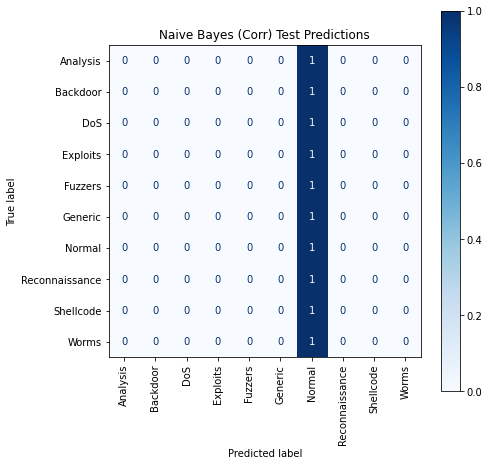

In [51]:
plt_norm_confmat(gnb_corr_final, test_std_corr, y_test, 'Naive Bayes (Corr) Test Predictions', 
                 fname='final_gnb_corr_conf_mat', labels=class_names)

In [52]:
joblib.dump(final_rep_dict_gnb_corr, 'final_rep_dict_gnb_corr.pkl')

['final_rep_dict_gnb_corr.pkl']

In [53]:
joblib.dump(final_conf_mat_gnb_corr, 'final_conf_mat_gnb_corr.pkl')

['final_conf_mat_gnb_corr.pkl']

#### Random Forest optimum features

In [58]:
y_pred_final_gnb_RF = gnb_RF_final.predict(test_std_RF)

In [59]:
final_conf_mat_gnb_RF, final_class_rep_gnb_RF, final_rep_dict_gnb_RF, final_acc_gnb_RF = gen_metrics(y_test, y_pred_final_gnb_RF)
print(final_class_rep_gnb_RF)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.00      0.00      0.00       583
           2       0.10      0.29      0.15      4089
           3       0.23      0.53      0.32     11132
           4       0.00      0.00      0.00      6062
           5       0.94      0.96      0.95     18871
           6       1.00      0.03      0.05     37000
           7       0.13      0.95      0.23      3496
           8       0.00      0.00      0.00       378
           9       0.00      0.00      0.00        44

    accuracy                           0.36     82332
   macro avg       0.24      0.28      0.17     82332
weighted avg       0.71      0.36      0.30     82332



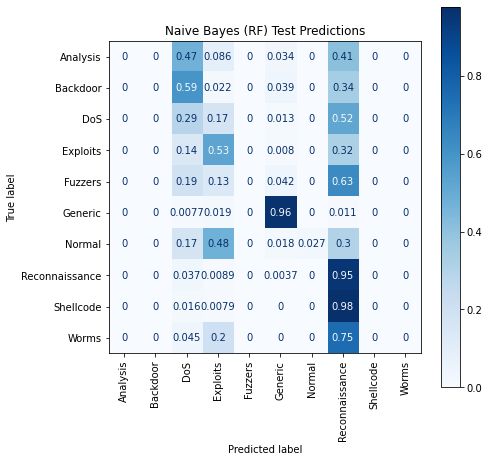

In [60]:
plt_norm_confmat(gnb_RF_final, test_std_RF, y_test, 'Naive Bayes (RF) Test Predictions', 
                 fname='final_gnb_RF_conf_mat', labels=class_names)

In [61]:
joblib.dump(final_rep_dict_gnb_RF, 'final_rep_dict_gnb_RF.pkl')

['final_rep_dict_gnb_RF.pkl']

In [62]:
joblib.dump(final_conf_mat_gnb_RF, 'final_conf_mat_gnb_RF.pkl')

['final_conf_mat_gnb_RF.pkl']

### K Nearest Neighbors

In [64]:
knn_ig_final = joblib.load('./data/knn_model_best_ig.pkl')
knn_anova_final = joblib.load('./data/knn_model_best_anova.pkl')
knn_vt_final = joblib.load('./data/knn_model_best_vt.pkl')
knn_mad_final = joblib.load('./data/knn_model_best_mad.pkl')
knn_corr_final = joblib.load('./data/knn_model_best_corr.pkl')
knn_RF_final = joblib.load('./data/knn_model_best_RF.pkl')

#### Info Gain

In [65]:
y_pred_final_knn_ig = knn_ig_final.predict(test_std_ig)

In [66]:
final_conf_mat_knn_ig, final_class_rep_knn_ig, final_rep_dict_knn_ig, final_acc_knn_ig = gen_metrics(y_test, y_pred_final_knn_ig)
print(final_class_rep_knn_ig)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.00      0.00      0.00       583
           2       0.10      0.29      0.15      4089
           3       0.23      0.53      0.32     11132
           4       0.00      0.00      0.00      6062
           5       0.94      0.96      0.95     18871
           6       1.00      0.03      0.05     37000
           7       0.13      0.95      0.23      3496
           8       0.00      0.00      0.00       378
           9       0.00      0.00      0.00        44

    accuracy                           0.36     82332
   macro avg       0.24      0.28      0.17     82332
weighted avg       0.71      0.36      0.30     82332



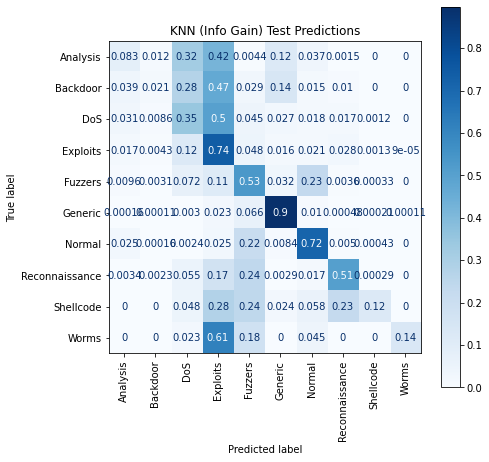

In [67]:
plt_norm_confmat(knn_ig_final, test_std_ig, y_test, 'KNN (Info Gain) Test Predictions', 
                 fname='final_knn_ig_conf_mat', labels=class_names)

In [68]:
joblib.dump(final_rep_dict_knn_ig, 'final_rep_dict_knn_ig.pkl')

['final_rep_dict_knn_ig.pkl']

In [69]:
joblib.dump(final_conf_mat_knn_ig, 'final_conf_mat_knn_ig.pkl')

['final_conf_mat_knn_ig.pkl']

#### ANOVA features

In [70]:
y_pred_final_knn_anova = knn_anova_final.predict(test_std_anova)

In [71]:
final_conf_mat_knn_anova, final_class_rep_knn_anova, final_rep_dict_knn_anova, final_acc_knn_anova = gen_metrics(y_test, y_pred_final_knn_anova)
print(final_class_rep_knn_anova)

              precision    recall  f1-score   support

           0       0.02      0.02      0.02       677
           1       0.02      0.03      0.02       583
           2       0.16      0.20      0.18      4089
           3       0.44      0.69      0.54     11132
           4       0.24      0.53      0.33      6062
           5       0.89      0.75      0.81     18871
           6       0.92      0.66      0.77     37000
           7       0.37      0.23      0.28      3496
           8       0.00      0.00      0.00       378
           9       0.33      0.02      0.04        44

    accuracy                           0.62     82332
   macro avg       0.34      0.31      0.30     82332
weighted avg       0.72      0.62      0.65     82332



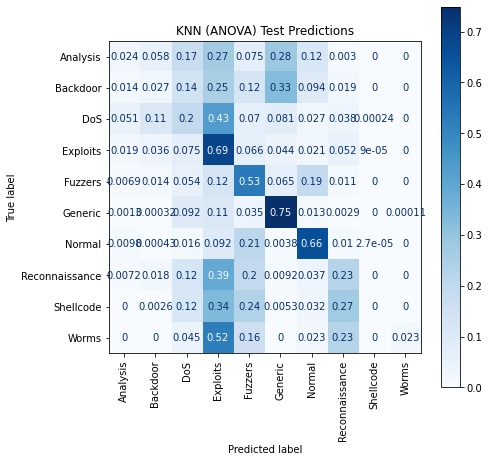

In [72]:
plt_norm_confmat(knn_anova_final, test_std_anova, y_test, 'KNN (ANOVA) Test Predictions', 
                 fname='final_knn_anova_conf_mat', labels=class_names)

In [73]:
joblib.dump(final_rep_dict_knn_anova, 'final_rep_dict_knn_anova.pkl')

['final_rep_dict_knn_anova.pkl']

In [74]:
joblib.dump(final_conf_mat_knn_anova, 'final_conf_mat_knn_anova.pkl')

['final_conf_mat_knn_anova.pkl']

#### Variance Threshold features

In [75]:
y_pred_final_knn_vt = knn_vt_final.predict(test_std_vt)

In [76]:
final_conf_mat_knn_vt, final_class_rep_knn_vt, final_rep_dict_knn_vt, final_acc_knn_vt = gen_metrics(y_test, y_pred_final_knn_vt)
print(final_class_rep_knn_vt)

              precision    recall  f1-score   support

           0       0.02      0.00      0.01       677
           1       0.00      0.00      0.00       583
           2       0.24      0.10      0.14      4089
           3       0.45      0.67      0.54     11132
           4       0.18      0.55      0.27      6062
           5       0.92      0.56      0.70     18871
           6       0.95      0.61      0.75     37000
           7       0.24      0.33      0.28      3496
           8       0.01      0.09      0.01       378
           9       0.50      0.02      0.04        44

    accuracy                           0.56     82332
   macro avg       0.35      0.29      0.27     82332
weighted avg       0.74      0.56      0.61     82332



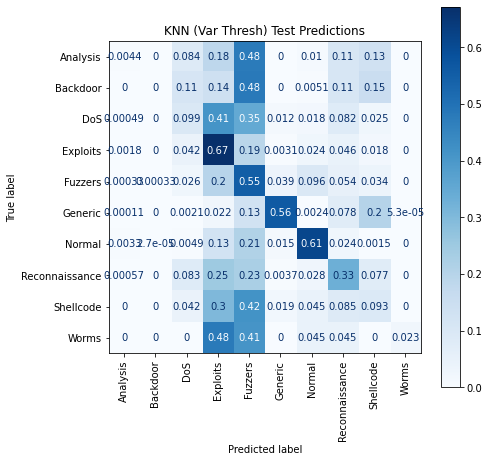

In [77]:
plt_norm_confmat(knn_vt_final, test_std_vt, y_test, 'KNN (Var Thresh) Test Predictions', 
                 fname='final_knn_vt_conf_mat', labels=class_names)

In [78]:
joblib.dump(final_rep_dict_knn_vt, 'final_rep_dict_knn_vt.pkl')

['final_rep_dict_knn_vt.pkl']

In [79]:
joblib.dump(final_conf_mat_knn_vt, 'final_conf_mat_knn_vt.pkl')

['final_conf_mat_knn_vt.pkl']

#### Median Absolute Deviation features

In [80]:
y_pred_final_knn_mad = knn_mad_final.predict(test_std_mad)

In [81]:
final_conf_mat_knn_mad, final_class_rep_knn_mad, final_rep_dict_knn_mad, final_acc_knn_mad = gen_metrics(y_test, y_pred_final_knn_mad)
print(final_class_rep_knn_mad)

              precision    recall  f1-score   support

           0       0.02      0.05      0.03       677
           1       0.02      0.05      0.03       583
           2       0.35      0.28      0.31      4089
           3       0.62      0.73      0.67     11132
           4       0.21      0.53      0.30      6062
           5       0.96      0.80      0.87     18871
           6       0.90      0.71      0.79     37000
           7       0.70      0.56      0.62      3496
           8       0.53      0.12      0.19       378
           9       0.60      0.14      0.22        44

    accuracy                           0.68     82332
   macro avg       0.49      0.40      0.41     82332
weighted avg       0.77      0.68      0.71     82332



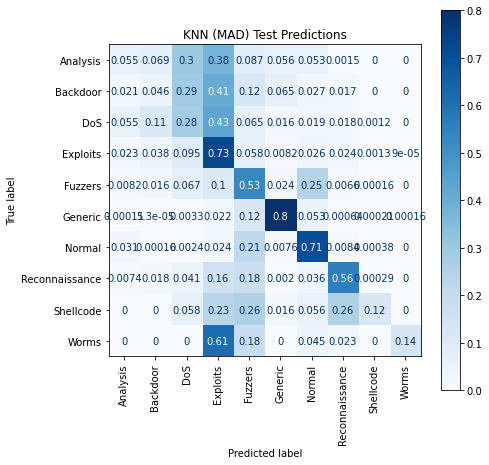

In [82]:
plt_norm_confmat(knn_mad_final, test_std_mad, y_test, 'KNN (MAD) Test Predictions', 
                 fname='final_knn_mad_conf_mat', labels=class_names)

In [83]:
joblib.dump(final_rep_dict_knn_mad, 'final_rep_dict_knn_mad.pkl')

['final_rep_dict_knn_mad.pkl']

In [84]:
joblib.dump(final_conf_mat_knn_mad, 'final_conf_mat_knn_mad.pkl')

['final_conf_mat_knn_mad.pkl']

#### Correlation features

In [85]:
y_pred_final_knn_corr = knn_corr_final.predict(test_std_corr)

In [86]:
final_conf_mat_knn_corr, final_class_rep_knn_corr, final_rep_dict_knn_corr, final_acc_knn_corr = gen_metrics(y_test, y_pred_final_knn_corr)
print(final_class_rep_knn_corr)

              precision    recall  f1-score   support

           0       0.01      0.01      0.01       677
           1       0.12      0.05      0.07       583
           2       0.32      0.37      0.34      4089
           3       0.57      0.72      0.64     11132
           4       0.24      0.51      0.33      6062
           5       0.95      0.95      0.95     18871
           6       0.91      0.72      0.80     37000
           7       0.69      0.37      0.48      3496
           8       0.28      0.11      0.16       378
           9       0.75      0.07      0.12        44

    accuracy                           0.71     82332
   macro avg       0.49      0.39      0.39     82332
weighted avg       0.77      0.71      0.73     82332



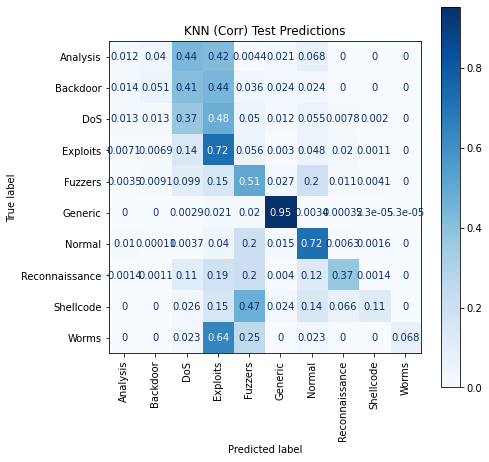

In [87]:
plt_norm_confmat(knn_corr_final, test_std_corr, y_test, 'KNN (Corr) Test Predictions', 
                 fname='final_knn_corr_conf_mat', labels=class_names)

In [88]:
joblib.dump(final_rep_dict_knn_corr, 'final_rep_dict_knn_corr.pkl')

['final_rep_dict_knn_corr.pkl']

In [89]:
joblib.dump(final_conf_mat_knn_corr, 'final_conf_mat_knn_corr.pkl')

['final_conf_mat_knn_corr.pkl']

#### Random Forest optimum features

In [90]:
y_pred_final_knn_RF = knn_RF_final.predict(test_std_RF)

In [91]:
final_conf_mat_knn_RF, final_class_rep_knn_RF, final_rep_dict_knn_RF, final_acc_knn_RF = gen_metrics(y_test, y_pred_final_knn_RF)
print(final_class_rep_knn_RF)

              precision    recall  f1-score   support

           0       0.01      0.01      0.01       677
           1       0.02      0.03      0.02       583
           2       0.31      0.26      0.28      4089
           3       0.59      0.74      0.66     11132
           4       0.25      0.57      0.35      6062
           5       1.00      0.96      0.98     18871
           6       0.95      0.69      0.80     37000
           7       0.63      0.69      0.66      3496
           8       0.50      0.14      0.22       378
           9       1.00      0.02      0.04        44

    accuracy                           0.72     82332
   macro avg       0.53      0.41      0.40     82332
weighted avg       0.80      0.72      0.74     82332



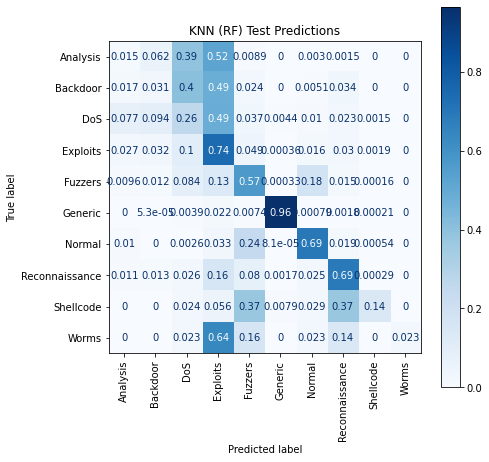

In [92]:
plt_norm_confmat(knn_RF_final, test_std_RF, y_test, 'KNN (RF) Test Predictions', 
                 fname='final_knn_RF_conf_mat', labels=class_names)

In [93]:
joblib.dump(final_rep_dict_knn_RF, 'final_rep_dict_knn_RF.pkl')

['final_rep_dict_knn_RF.pkl']

In [94]:
joblib.dump(final_conf_mat_knn_RF, 'final_conf_mat_knn_RF.pkl')

['final_conf_mat_knn_RF.pkl']